# Imports and Dataset Load

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import time

from tensorflow import keras as tfk
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import schedules
from tensorflow_addons.optimizers import AdamW

from qkeras import *
from qkeras.quantizers import *

import ad

from ad import utils
from ad.models.jointvae import JointVAE
from ad.models.qjointvae import QJointVAE

from typing import List


ad.constants.set_labels(['qcd', 'top'], bkg_index=0)
ad.constants.set_masses(masses={i: {i: i} for i in range(2)})

utils.set_random_seed(42)
ad.plot.set_style()

%load_ext autoreload
%autoreload 2

2023-10-23 15:59:00.613330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-23 15:59:00.613404: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Random seed 42 set.


## Load Data

In [4]:
# load all the data (both classes)
data = np.load('drive/MyDrive/qcd_vs_top_pt.npz')

x = data['images']
y = data['labels']

print(x.shape)
# divide data per-class
qcd = {k: v[y == 0] for k, v in data.items()}  # <-- train on this
top = {k: v[y == 1] for k, v in data.items()}

Mounted at /content/drive
(403000, 40, 40, 1)


# JointVAE Model Optimization

## I. Complete JointVAE

In [ ]:
######################
#######  MODEL  ######
######################

model = JointVAE(
                      name = 'JointVAE',
                      continous_latent = 32,
                      discrete_latent= 20,
                      temperature = 50,
                      alpha = 1.,
                      beta = 3e3,
                      eps_kl = 1e-5,

                      encoder=dict(depths=(1, 1, 1, 1),
                                   filters=[32, 64, 128, 128],
                                   activation = tf.nn.leaky_relu ,
                                   kernel_initializer='he_normal',
                                   groups=4,
                                   input_shape=(40, 40, 1)),
                      decoder=dict(depths=(1, 1, 1, 1),
                                   filters=[32, 128, 128, 64],
                                   activation = tf.nn.leaky_relu ,
                                   kernel_initializer='he_normal',
                                   groups=8,
                                   size = (3, 3, 256),
                                   crop=(40, 40))
                        )
model.summary()

Model: "Res-Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 dconv-b0 (ConvLayer)           (None, 20, 20, 32)   384         ['image[0][0]']                  
                                                                                                  
 conv1-b0_0 (ConvLayer)         (None, 20, 20, 32)   2400        ['dconv-b0[0][0]']               
                                                                                                  
 conv2-b0_0 (ConvLayer)         (None, 20, 20, 32)   2400        ['conv1-b0_0[0][0]']             
                                                                                        

In [ ]:
######################
####### COMPILE ######
######################

model.compile(optimizer=AdamW(weight_decay=1e-3, clipnorm=1)) #run_eagerly=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=True, patience=4,
                                              restore_best_weights=True)

checkpoint = utils.get_checkpoint(path=f'jointvae',
                                  monitor='val_loss', mode='min', best_only=False)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),


#######################
####### TRAINING ######
#######################

start_loop = time.time()
h = model.fit(x = x_train,
              validation_data= (x_valid,),
              verbose= 1,
              epochs = 6,
              batch_size=128,
              callbacks=[early_stop, checkpoint, reduceLR])
print("\nTotal time taken: %.2fmin" % ((time.time() - start_loop)/60.) )
#MSE < 0.1, SSIM > 0.98, PSNR > 50

Epoch 1/6
1181/1181 [==============================] - 346s 274ms/step - loss: 4200.6959 - reconstruction_loss: 7.3639 - kl_cont_loss: 748.6319 - kl_disc_loss: 14.9076 - mse: 0.5407 - psnr: 40.2496 - ssim: 0.9374 - val_loss: 8.4241 - val_reconstruction_loss: 6.0601 - val_kl_cont_loss: 2.2881 - val_kl_disc_loss: 0.0759 - val_mse: 0.1878 - val_psnr: 40.3907 - val_ssim: 0.9421 - lr: 0.0010
Epoch 2/6
1181/1181 [==============================] - 318s 269ms/step - loss: 7.8538 - reconstruction_loss: 6.0566 - kl_cont_loss: 0.6216 - kl_disc_loss: 0.0094 - mse: 0.1897 - psnr: 40.3722 - ssim: 0.9418 - val_loss: 6.0559 - val_reconstruction_loss: 6.0549 - val_kl_cont_loss: 0.0012 - val_kl_disc_loss: -1.5944e-04 - val_mse: 0.1877 - val_psnr: 40.3891 - val_ssim: 0.9417 - lr: 0.0010
Epoch 3/6
1181/1181 [==============================] - 318s 269ms/step - loss: 6.0535 - reconstruction_loss: 6.0539 - kl_cont_loss: 4.4274e-04 - kl_disc_loss: -3.0606e-04 - mse: 0.1896 - psnr: 40.3726 - ssim: 0.9418 - val

### Load from Checkpoint

In [ ]:
model.load_weights('weights/jointvae/weights-01-0.942')

### Anomaly Detection Evaluation

#### Weight Distributions

-0.3476516
0.36517295


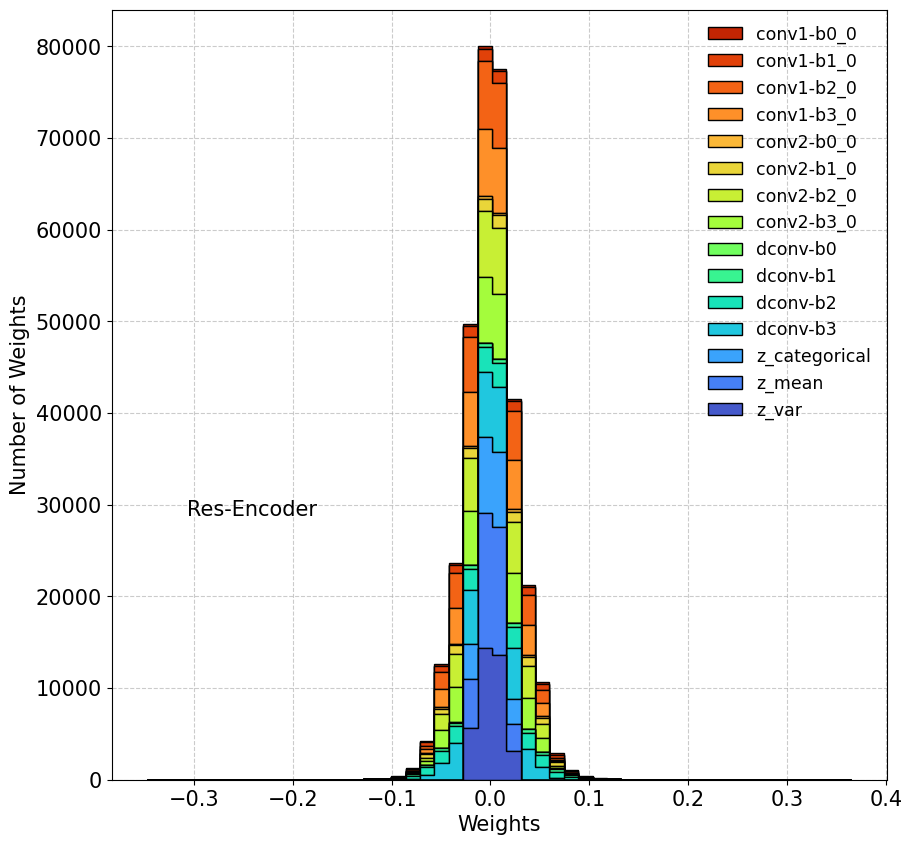

-0.17084439
0.18100202


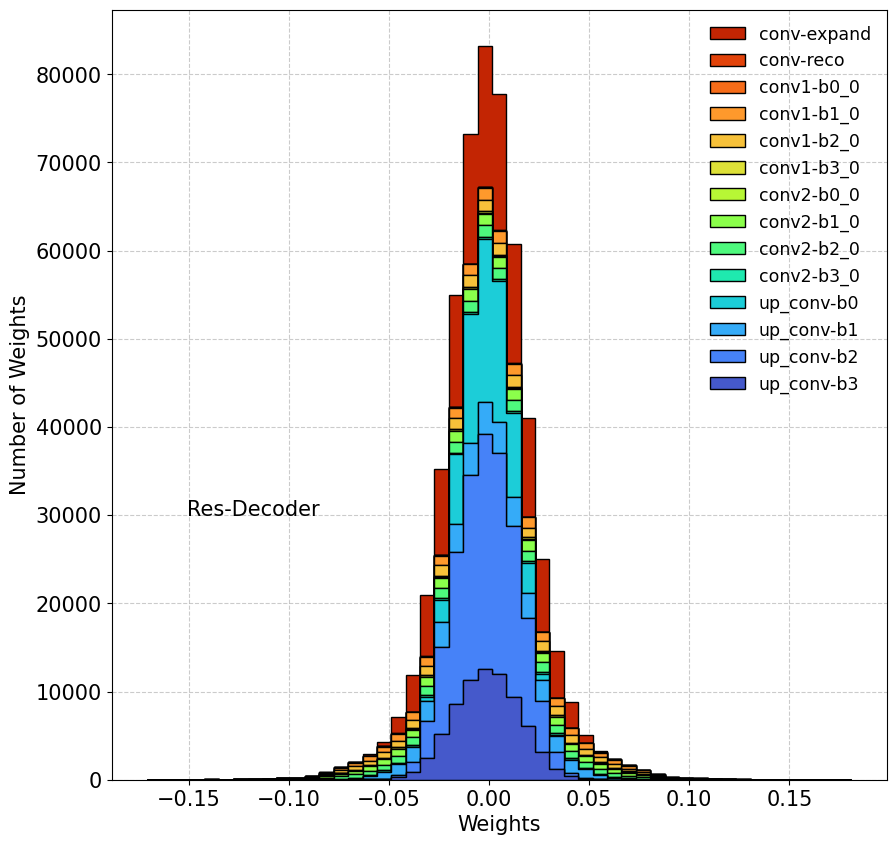

In [ ]:
ad.plot.doWeights(model.encoder)
ad.plot.doWeights(model.decoder)

In [ ]:
import sklearn.model_selection

top_train, top_valid = sklearn.model_selection.train_test_split(top['images'], train_size = 0.75 )
ytop_train, ytop_valid = sklearn.model_selection.train_test_split(top['labels'], train_size = 0.75 )

In [ ]:
from ad import utils
del top_train, ytop_train,# x_train, y_train,
utils.free_mem()

5915

In [ ]:
scores = ad.evaluation.compute_scores(model, x= np.concatenate((x_valid, top_valid),axis=0), batch_size=128)#256)
scores = {k: v.reshape((-1, 1)) for k, v in scores.items()}
scores =ad.evaluation.latents_as_scores(scores, np.concatenate ((y_valid, ytop_valid),axis=0), np.concatenate ((y_valid, ytop_valid),axis=0))

#### AD PLOTs

TPR corrispondent to 0.1% of FPR: 0.5060843672456575
energy_diff_1 (1), AUC = 84.17%


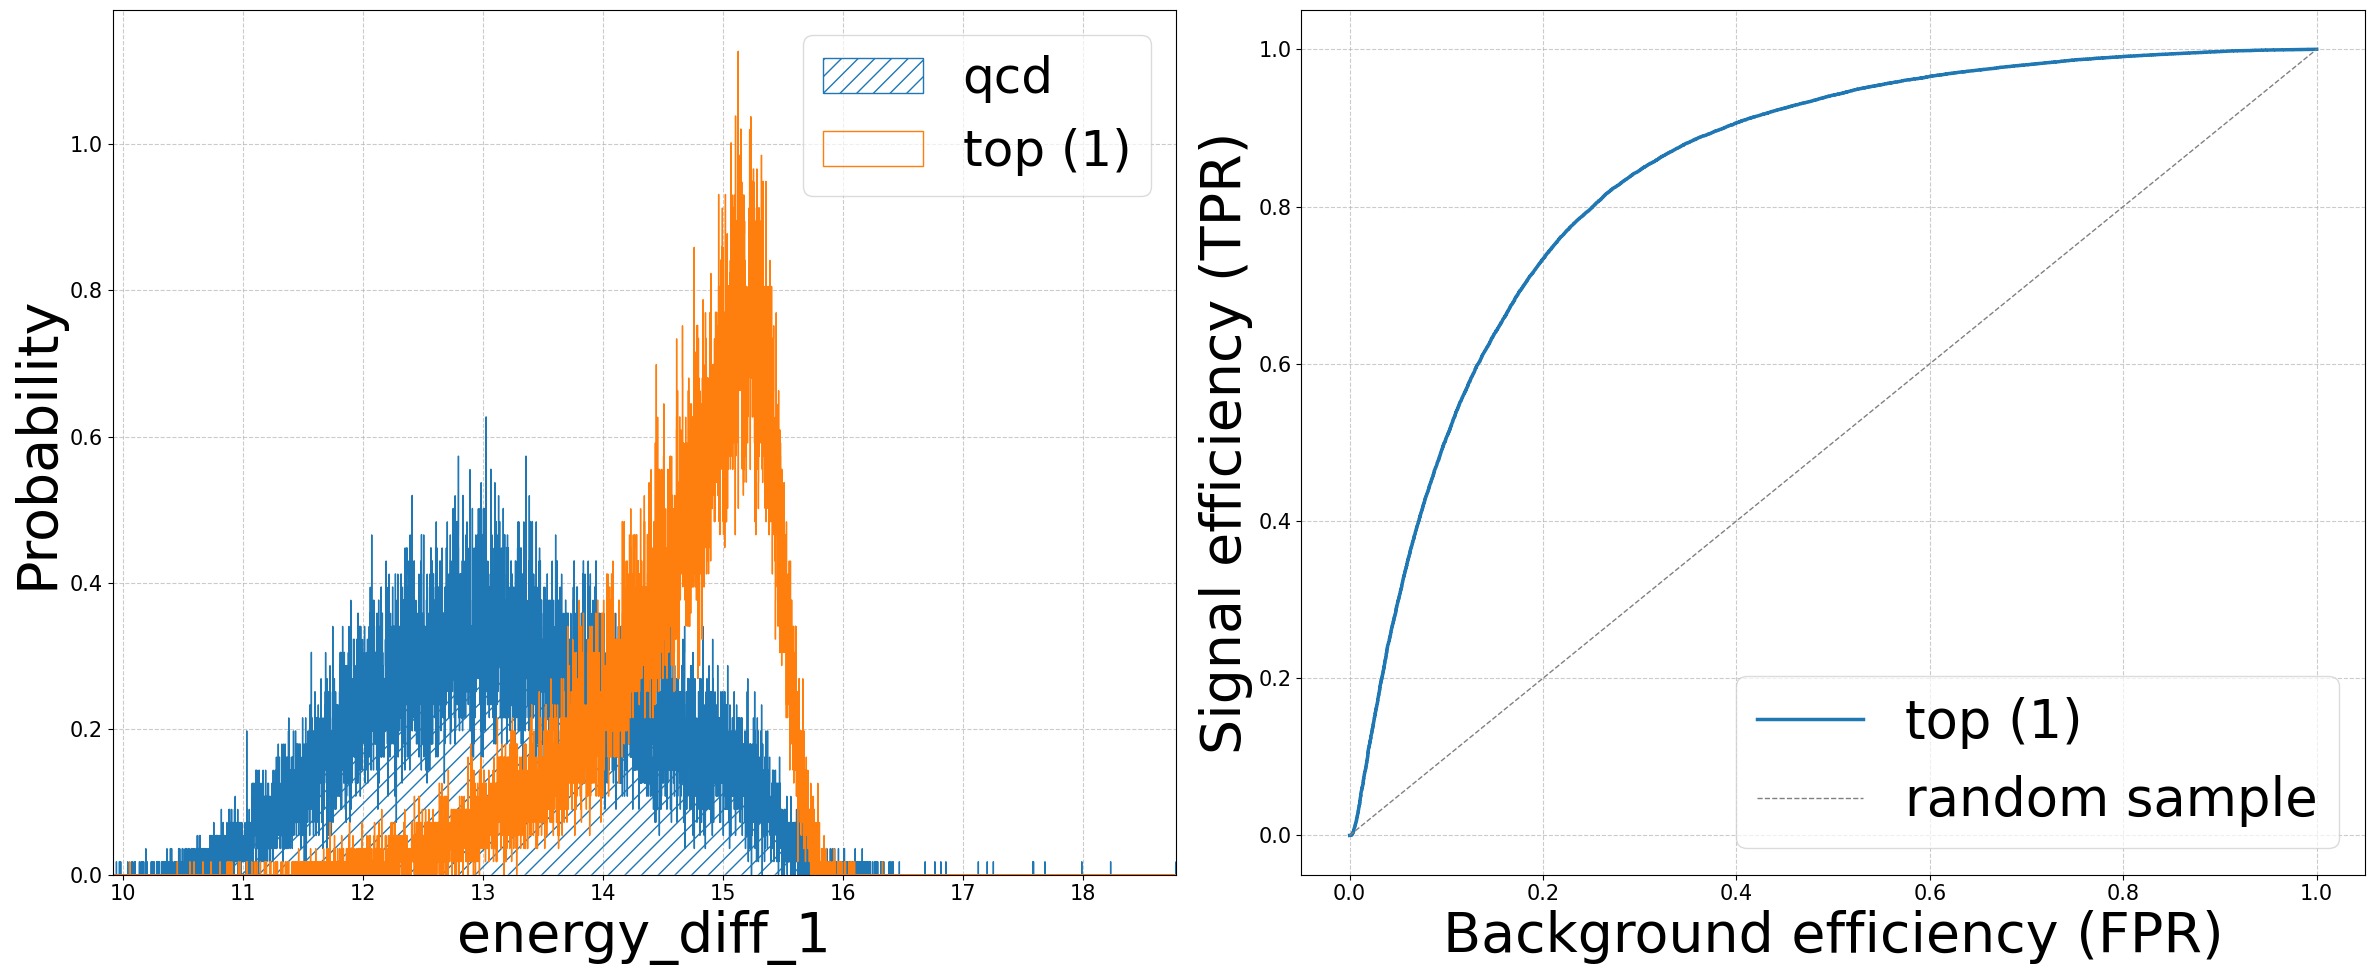

TPR corrispondent to 0.1% of FPR: 0.5889826302729528
bce_1 (1), AUC = 84.39%


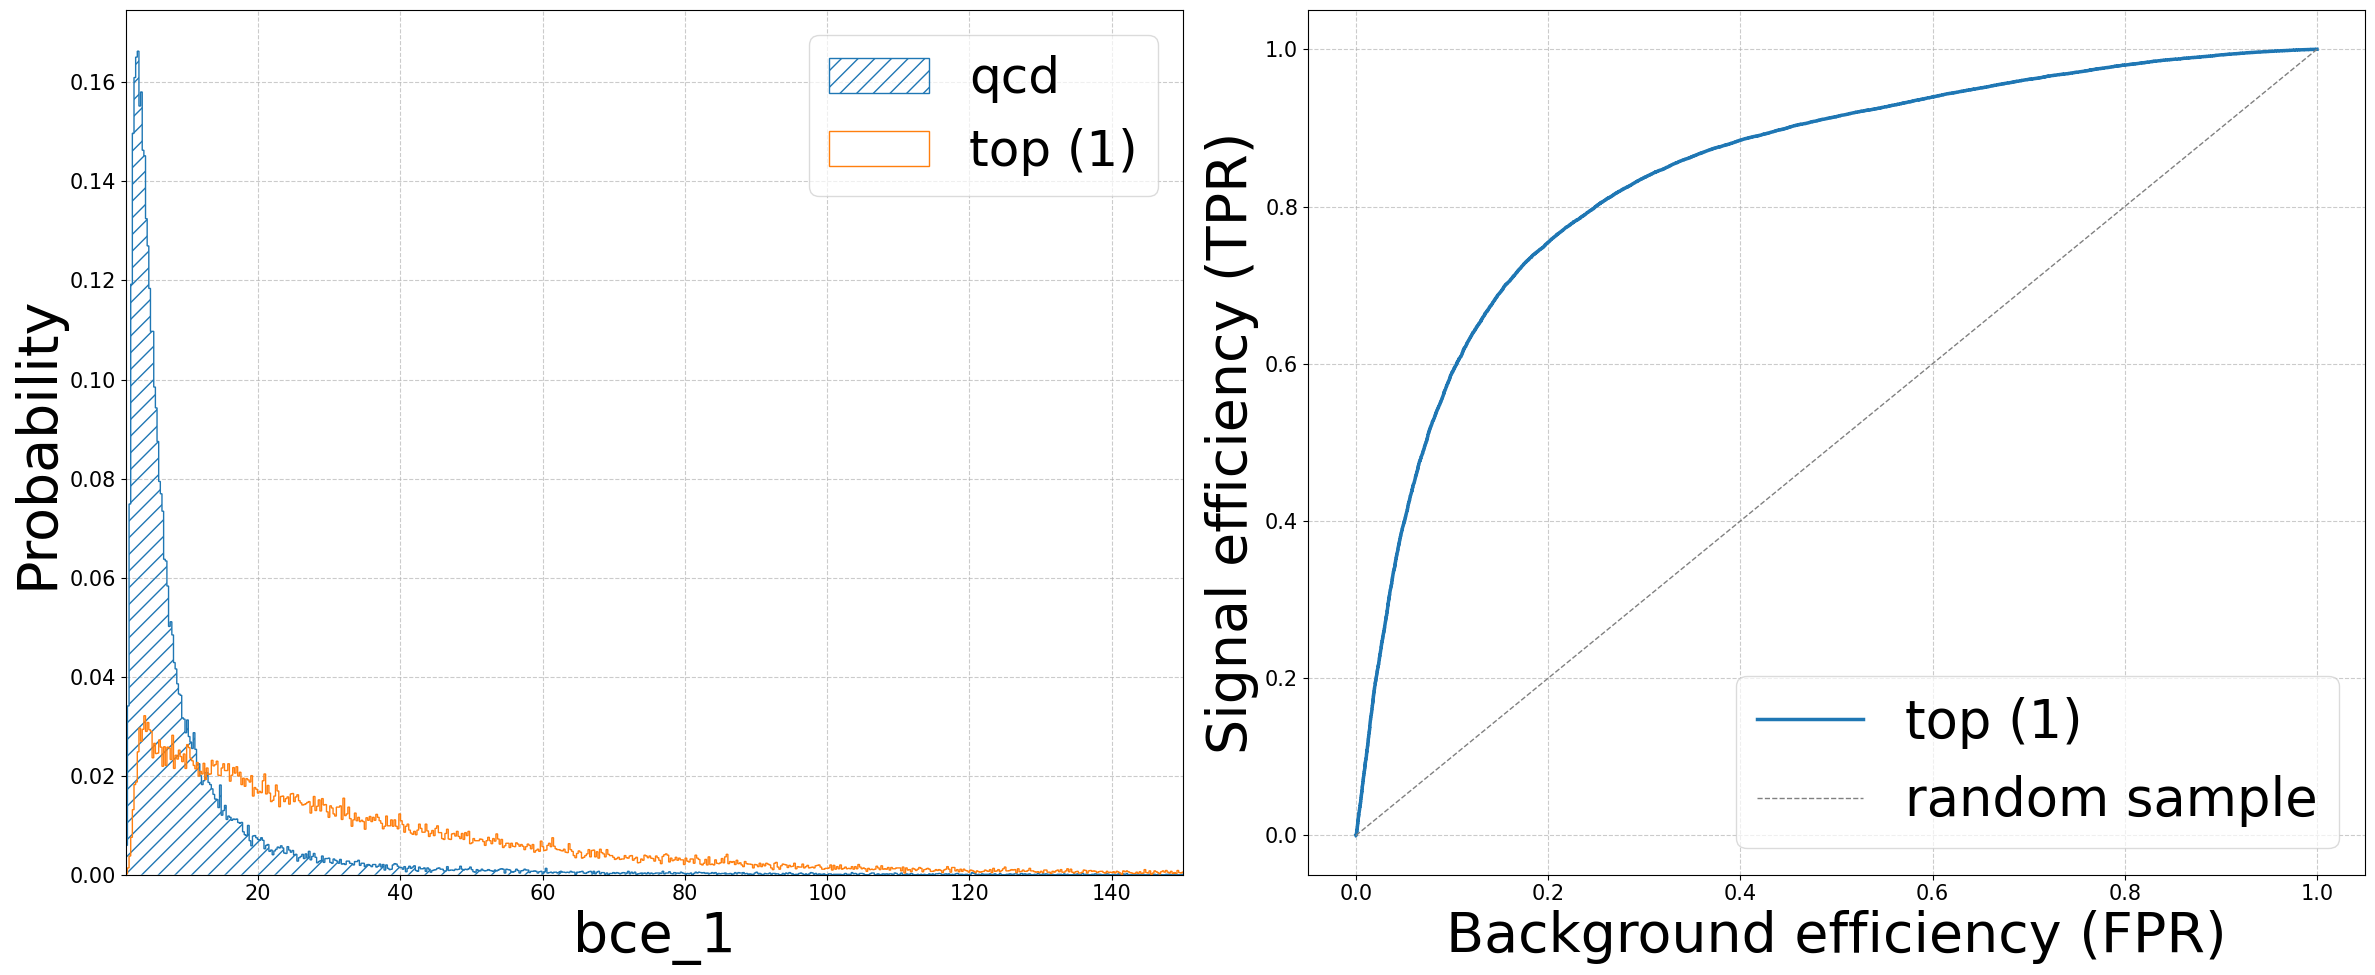

TPR corrispondent to 0.1% of FPR: 0.10203473945409429
dice_1 (1), AUC = 50.22%


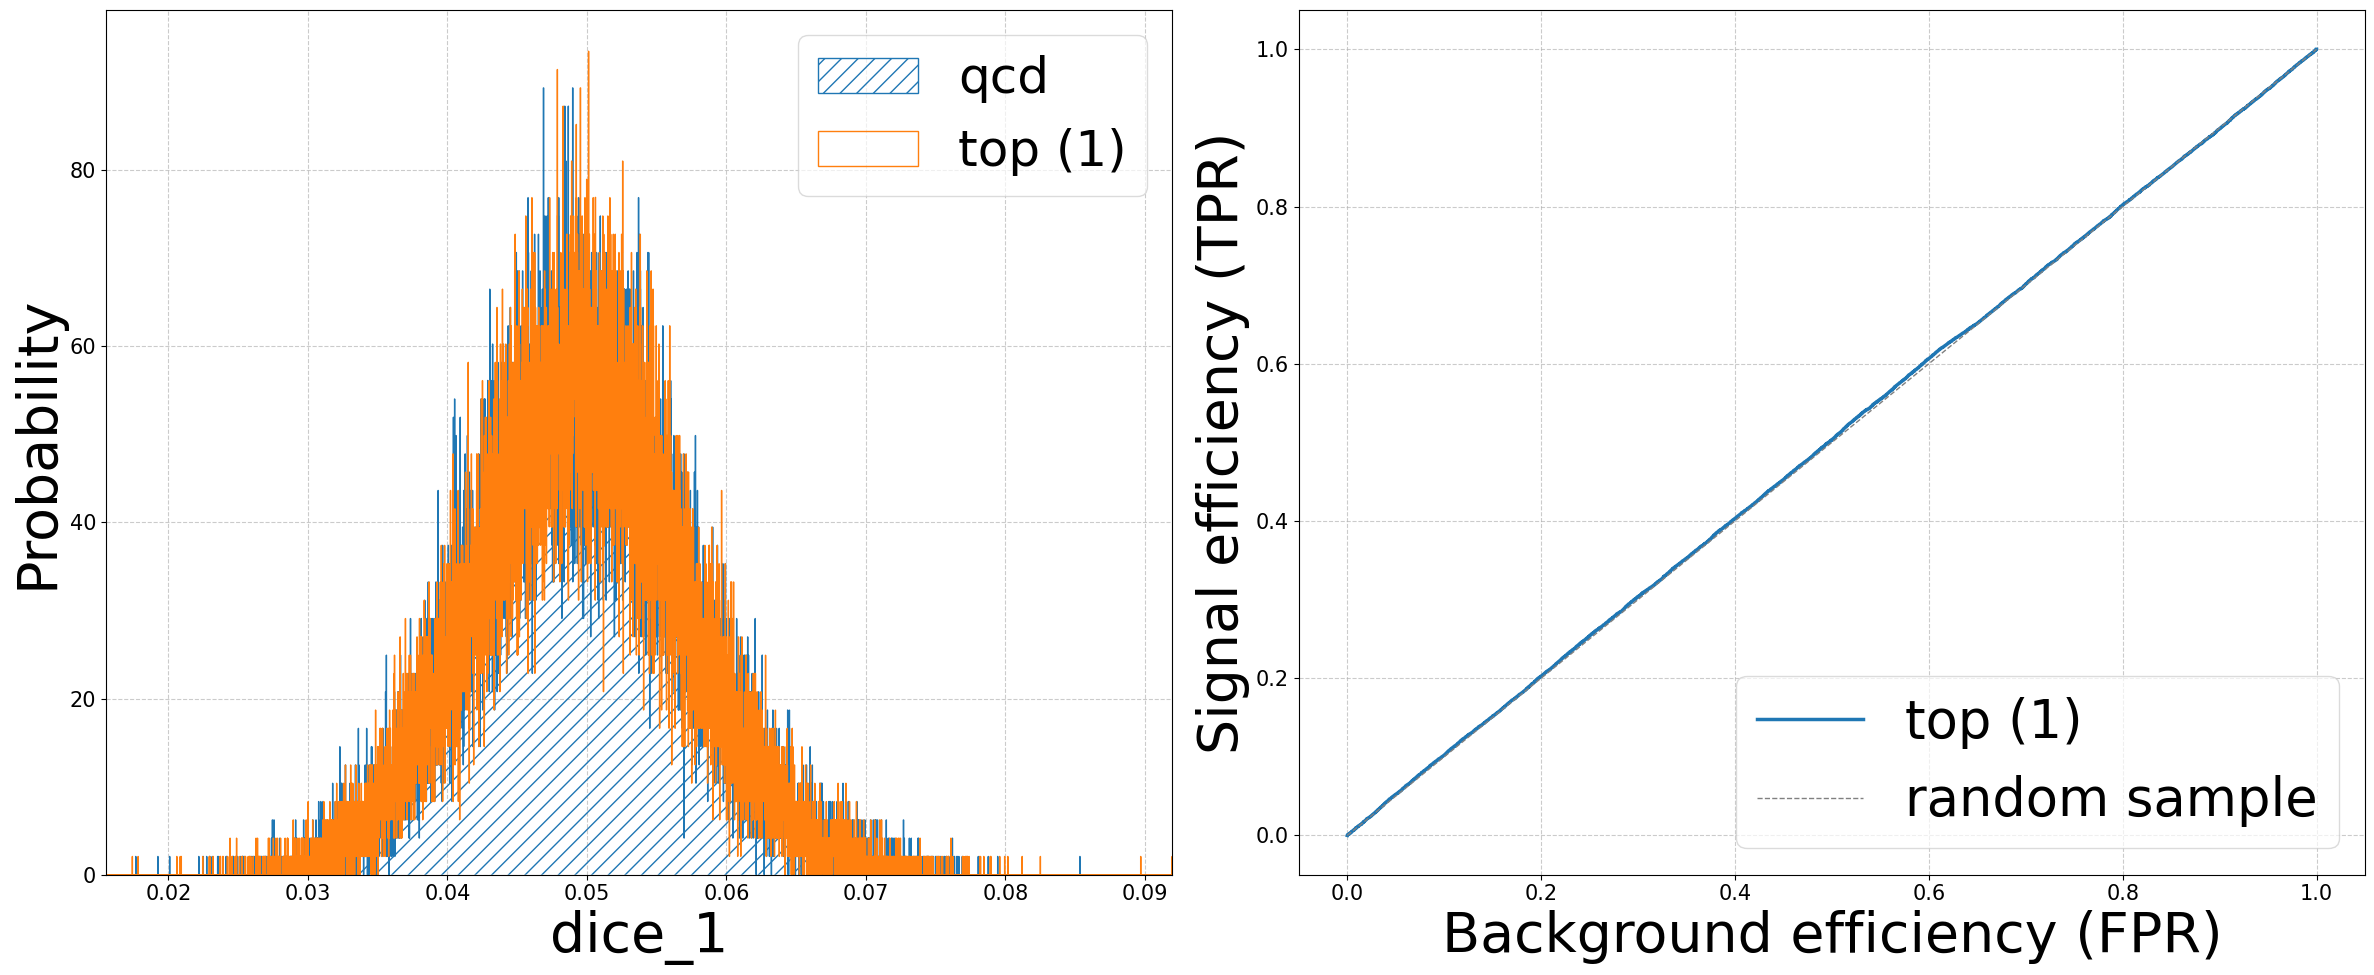

TPR corrispondent to 0.1% of FPR: 0.5893399503722084
total_1 (1), AUC = 85.07%


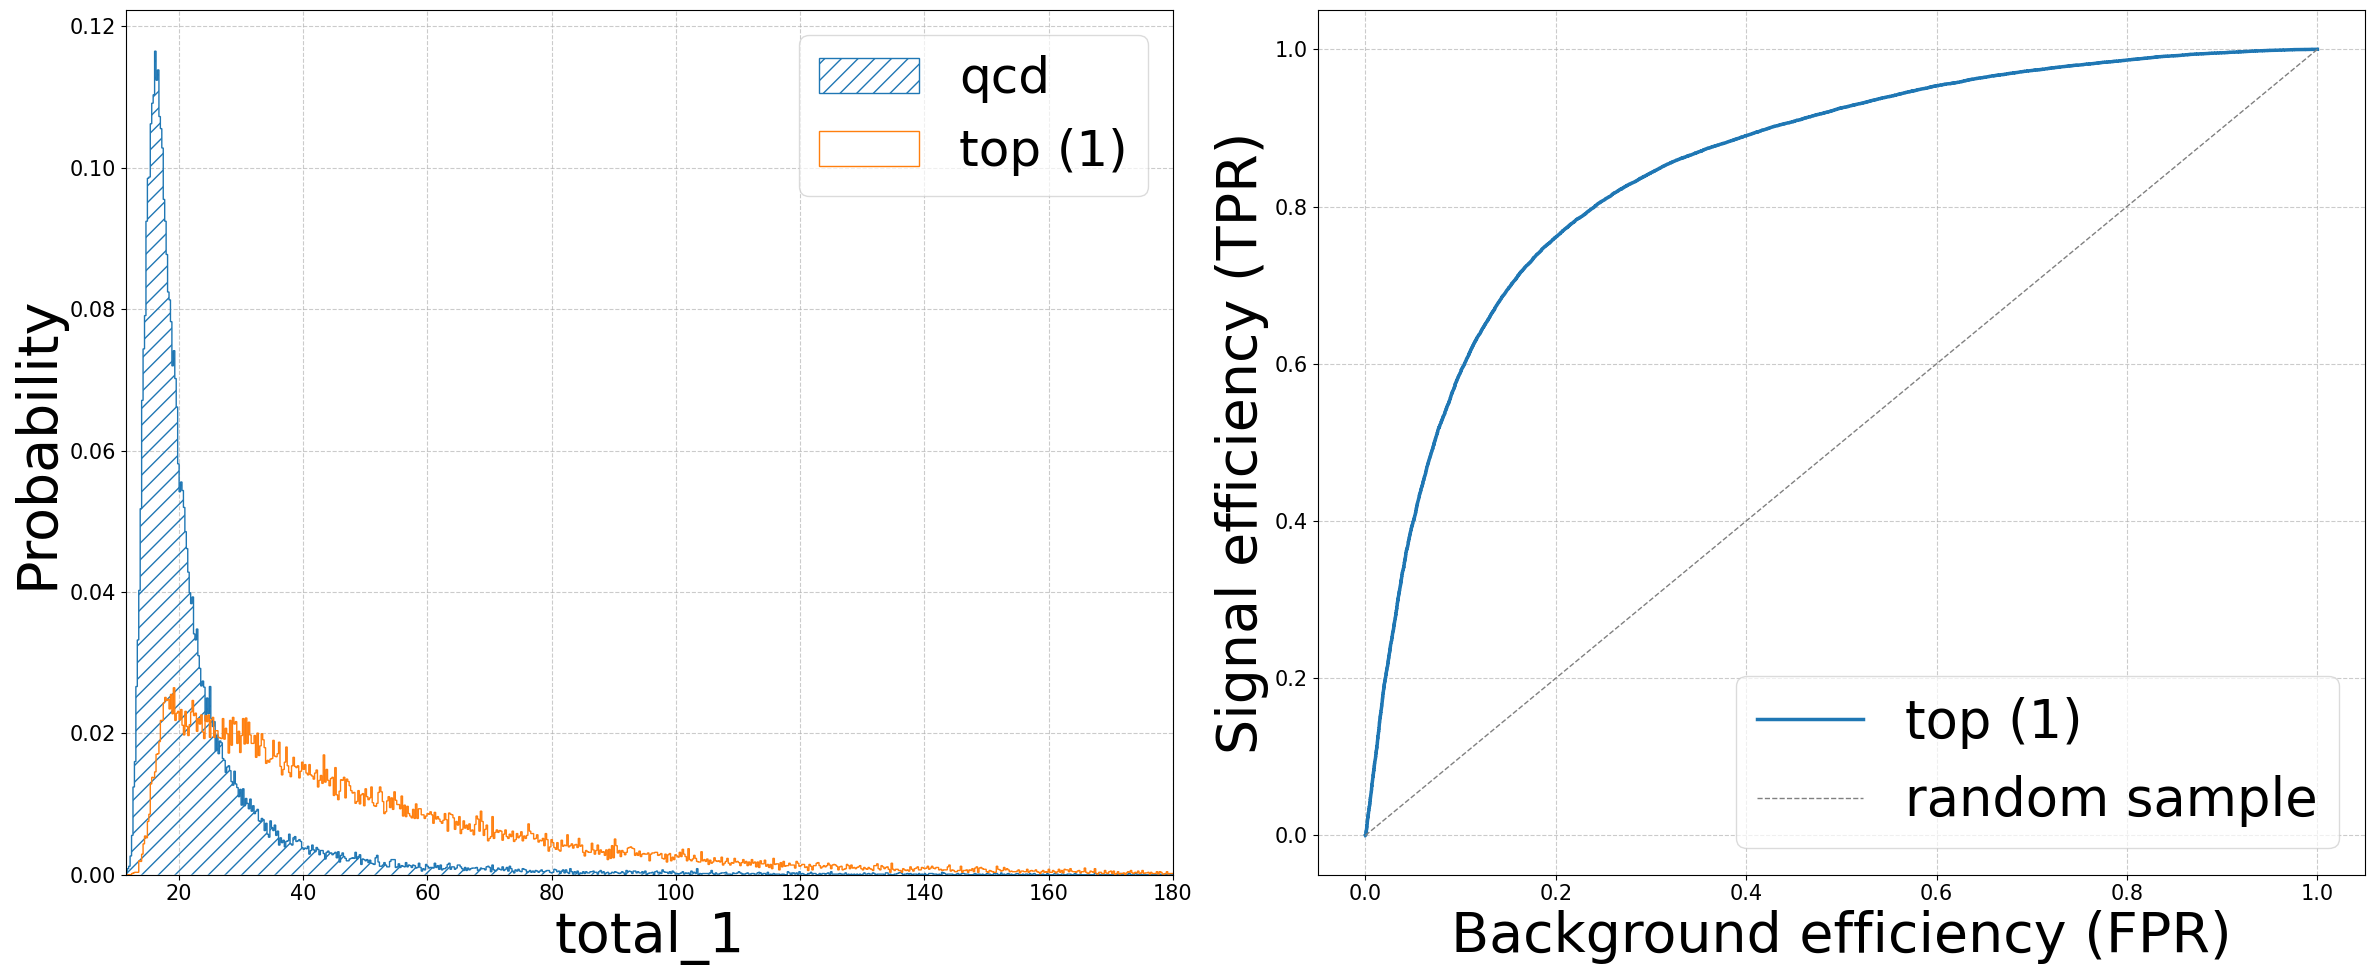

TPR corrispondent to 0.1% of FPR: 0.004208436724565757
mse_1 (1), AUC = 37.87%


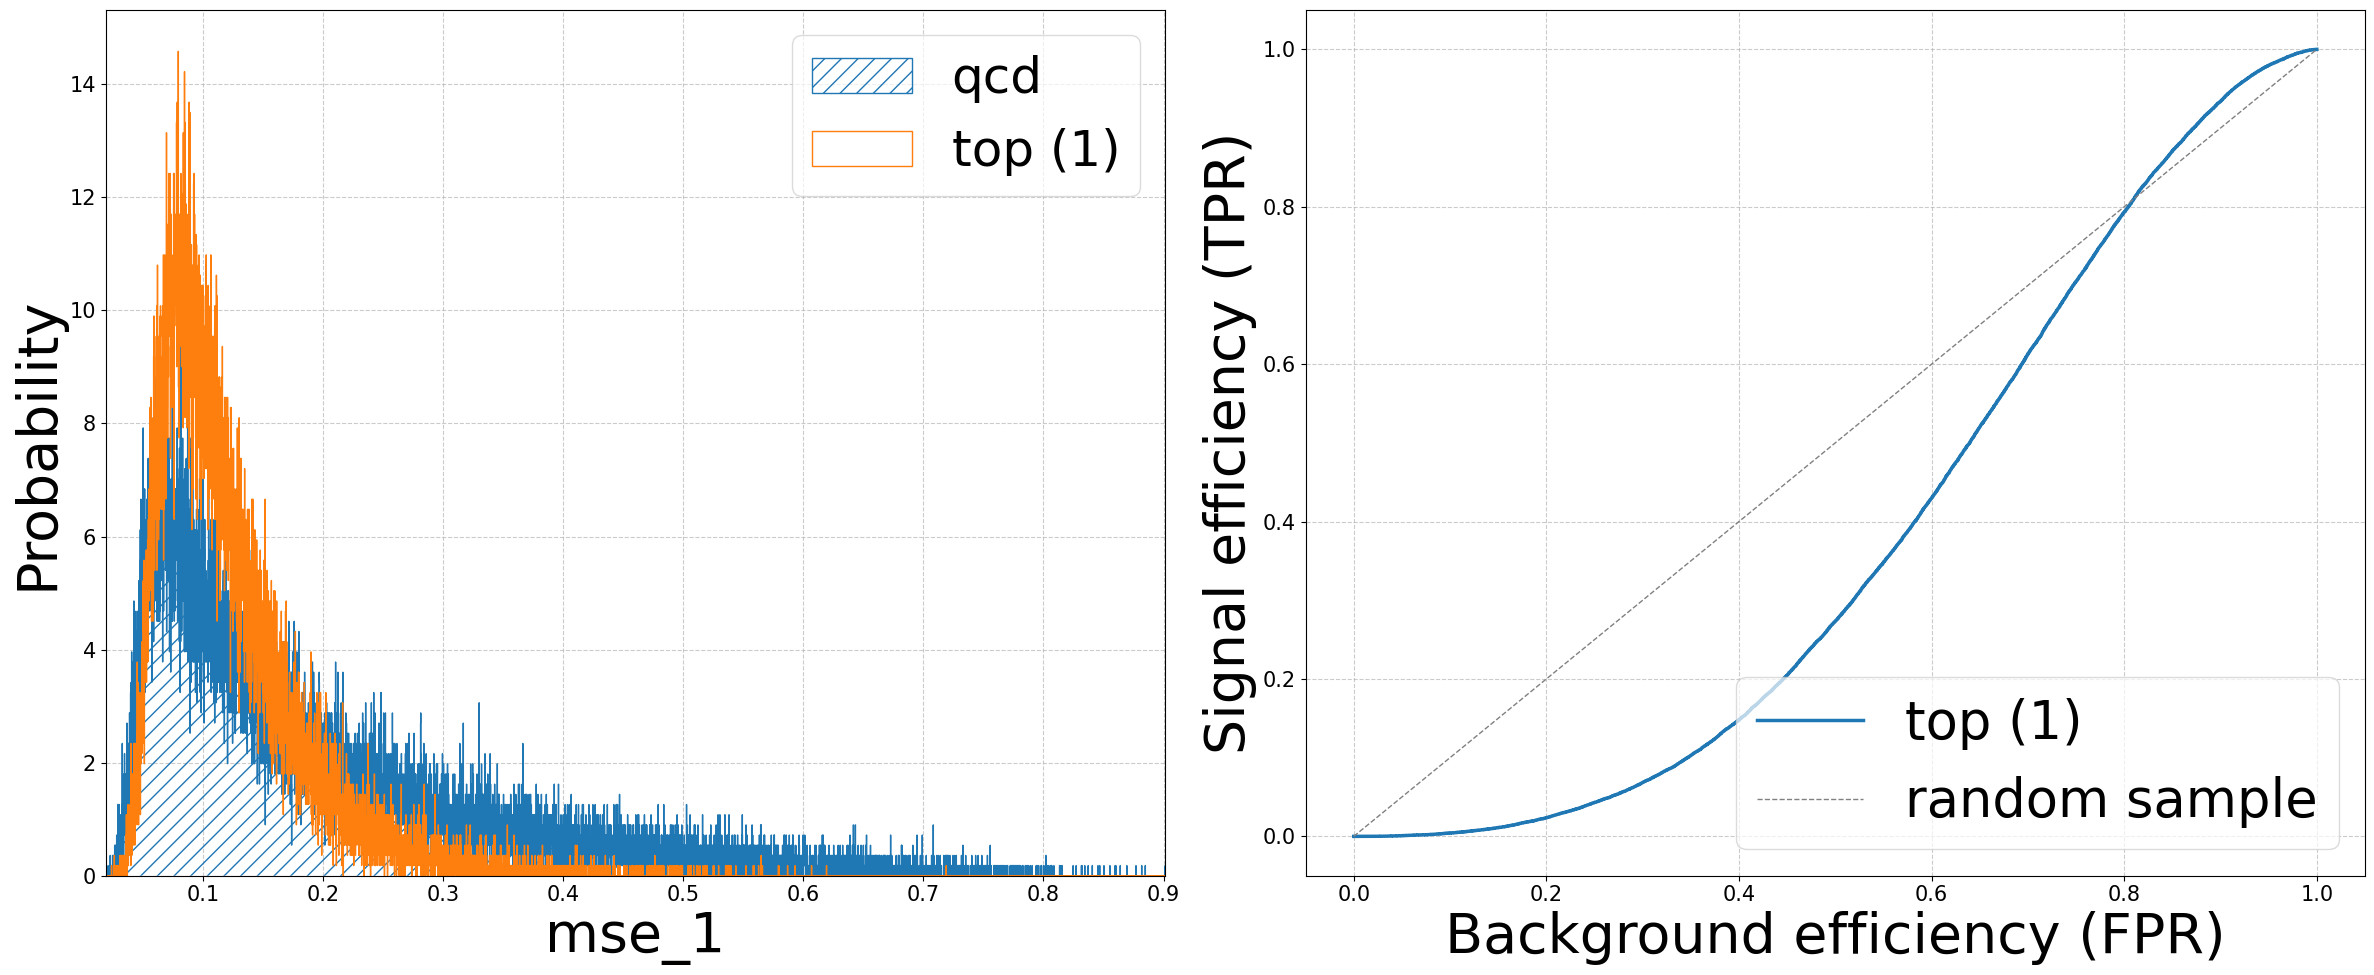

TPR corrispondent to 0.1% of FPR: 0.5118808933002481
kl_cont_1 (1), AUC = 78.28%


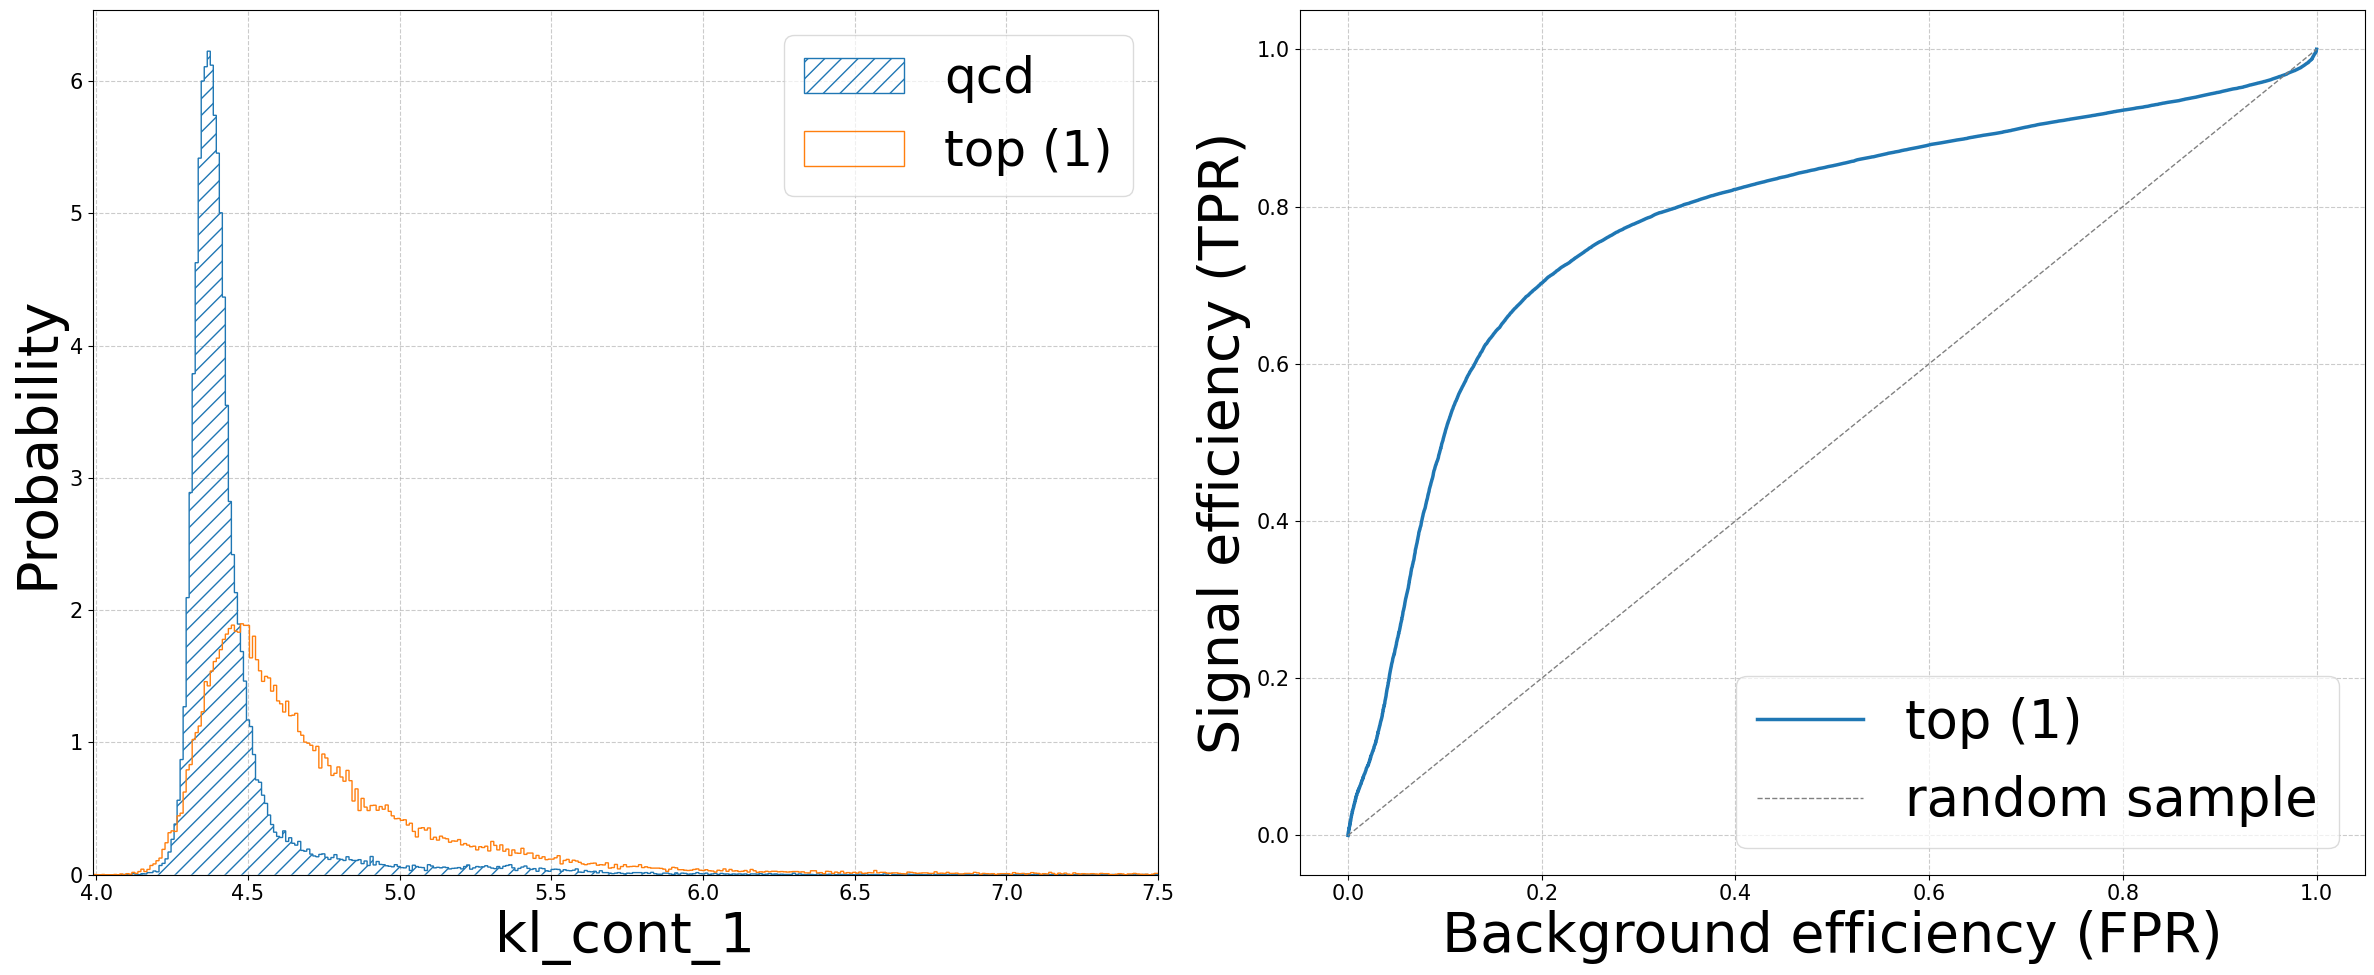

TPR corrispondent to 0.1% of FPR: 0.456575682382134
kl_disc_1 (1), AUC = 66.74%


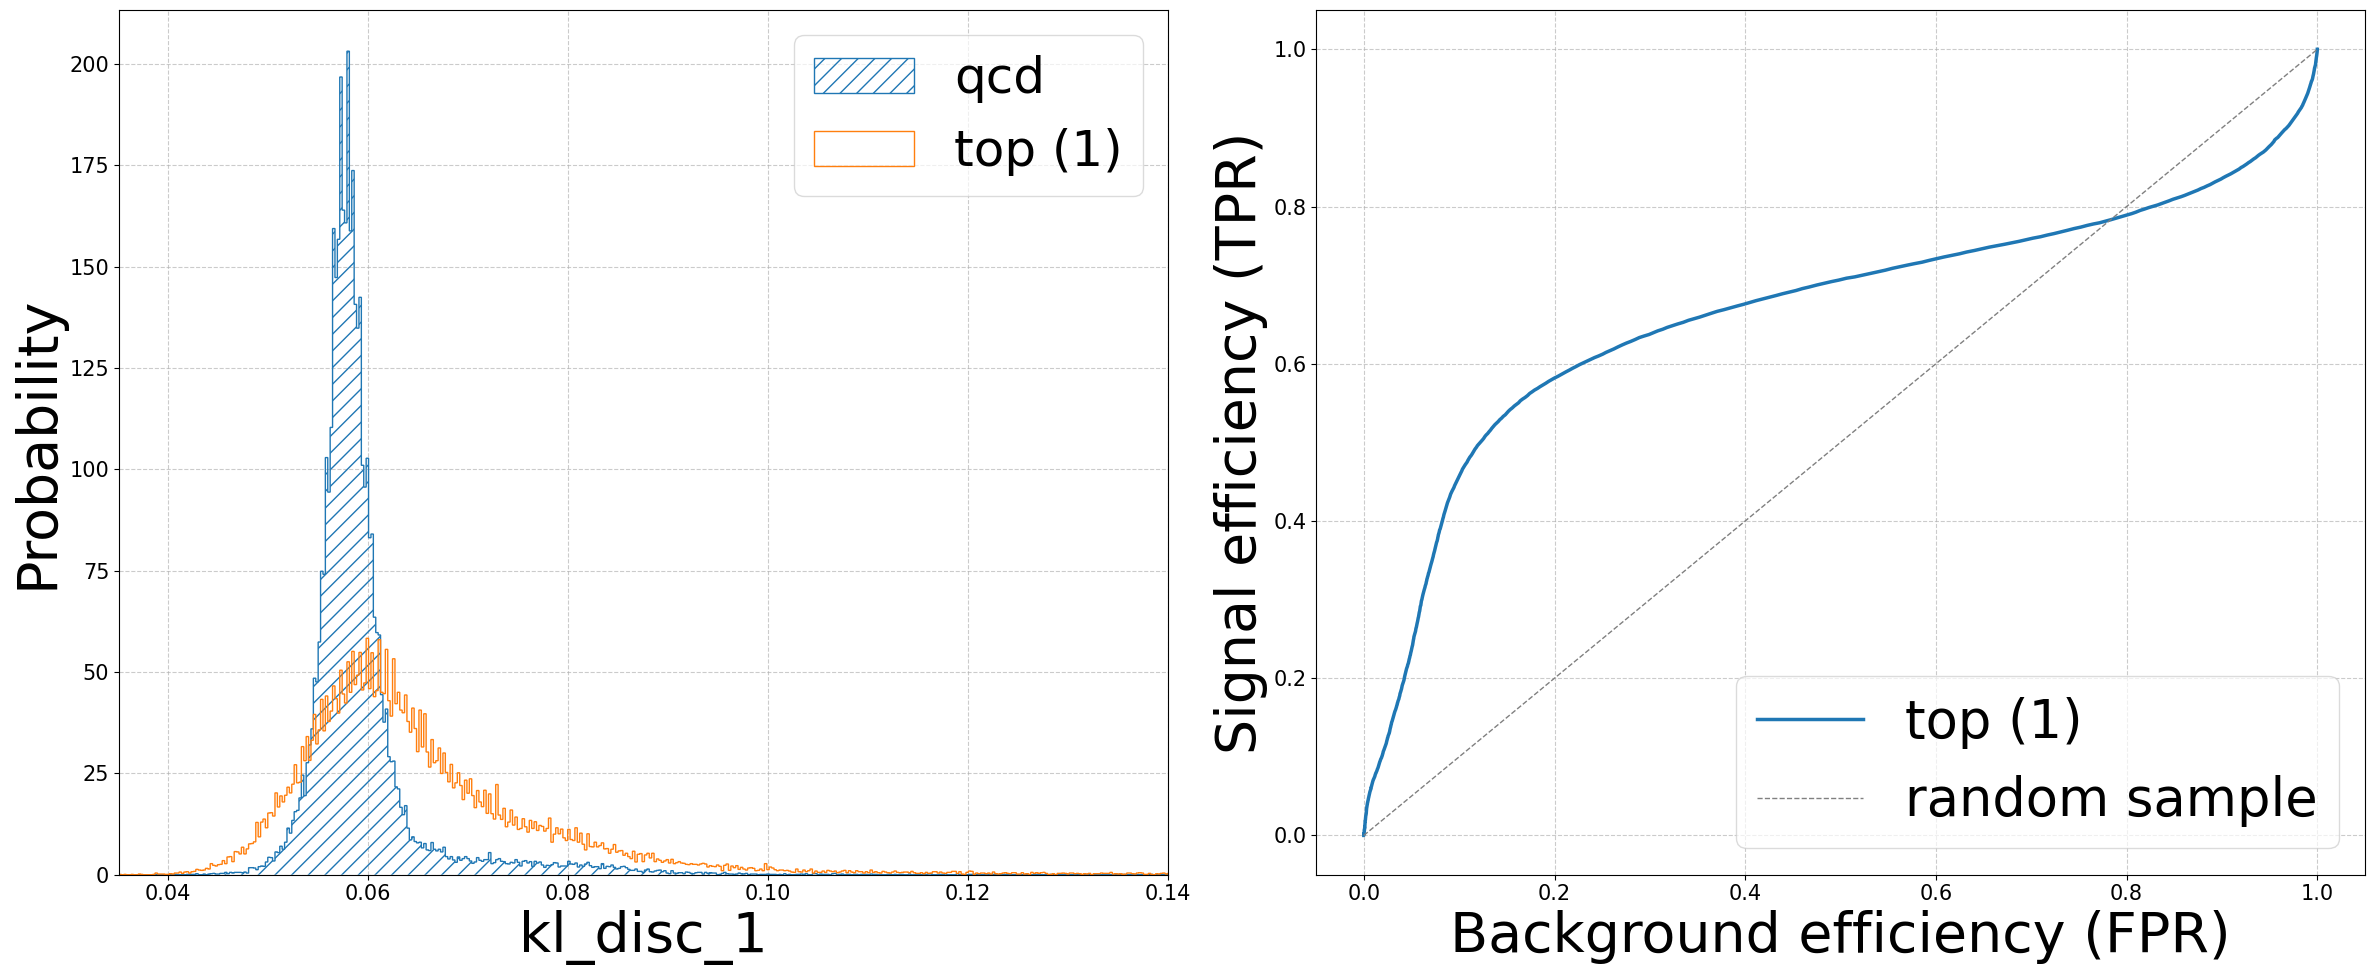

TPR corrispondent to 0.1% of FPR: 0.5111265508684864
kl_tot_1 (1), AUC = 78.32%


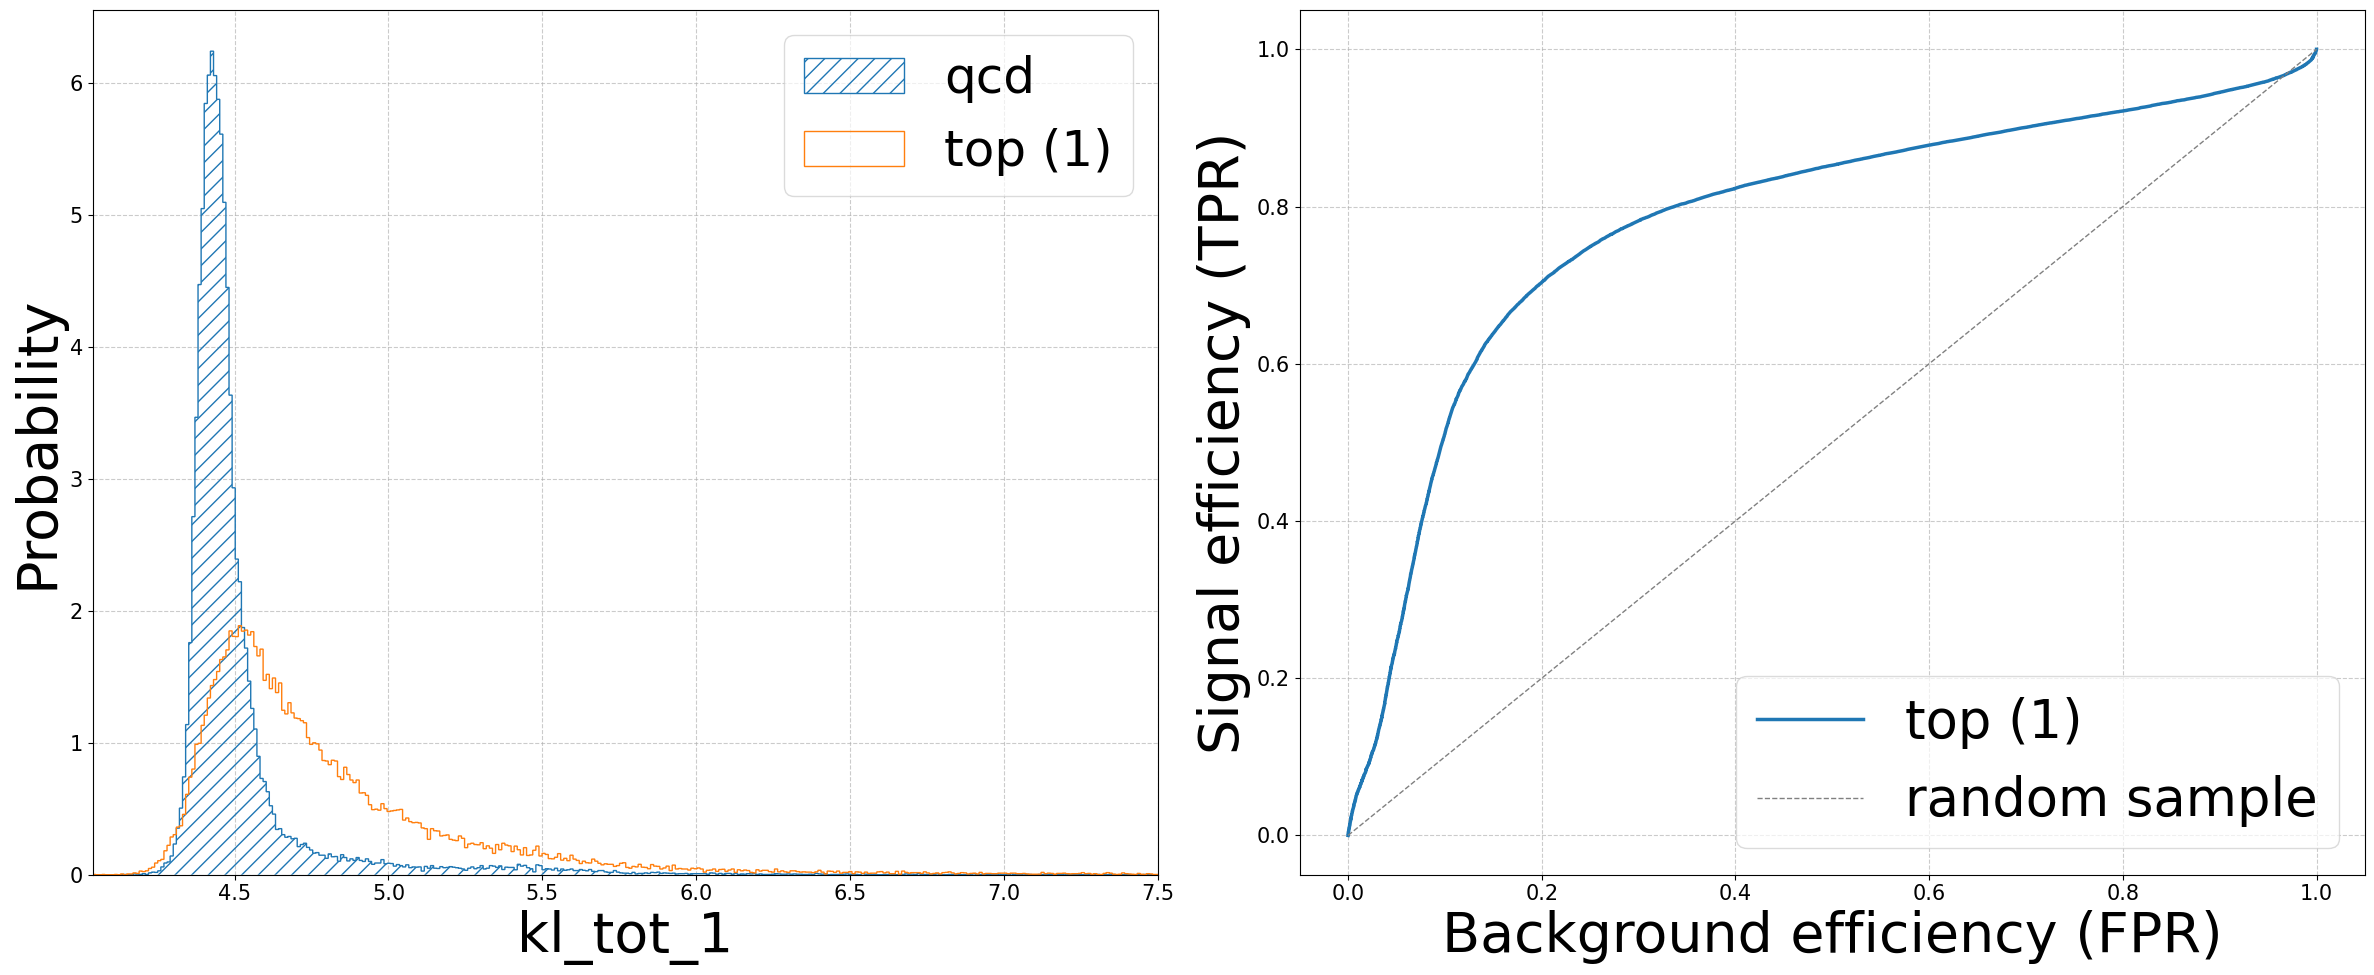

In [ ]:
curves = ad.plot.roc_per_mass(bkg_scores=scores['qcd'],
                              signal_scores=scores['top'],
                              bins = 8000,
                              fontsize=40,
                              x_limits={'bce_1': (0, 150),
                                        'total_1': (0, 180),
                                        'kl_cont_1': (0, 7.5),
                                        'kl_disc_1': (0, .14),
                                        'kl_tot_1': (0, 7.5), },
                              )

# QCD or what - JVAE Model

In [ ]:
from ad.models.qcd_what_ae import HeimelJVAE

model = HeimelJVAE(
                      name = 'HeimelJVAE',
                      image_shape=(40, 40, 1),
                      continous_latent = 32,
                      discrete_latent= 20,
                      temperature = 50,
                      beta = 3e3,
                      eps_kl = 1e-7,

                 encoder=dict(filters=[(10, None), (5, 5)],
                              units=[400, 100], kernel_initializer='he_uniform'),
                 decoder=dict(filters=[(5, 5), (5, 10)],
                              units=[100, 400], reshape_to=(20, 20, 1),
                              crop = (40,40),
                              bias=-1.0, kernel_initializer='he_uniform')

                 )

model.summary()


Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 conv1-0 (Conv2D)               (None, 40, 40, 10)   100         ['image[0][0]']                  
                                                                                                  
 PReLU1-0 (PReLU)               (None, 40, 40, 10)   10          ['conv1-0[0][0]']                
                                                                                                  
 avg_pool-0 (AveragePooling2D)  (None, 20, 20, 10)   0           ['PReLU1-0[0][0]']               
                                                                                            

## Compile and Training

In [ ]:
######################
####### COMPILE ######
######################

model.compile(optimizer=AdamW(weight_decay=1e-3, clipnorm=1)) #run_eagerly=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=True, patience=4,
                                              restore_best_weights=True)

checkpoint = utils.get_checkpoint(path=f'jointvae',
                                  monitor='val_loss', mode='min', best_only=False)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),


#######################
####### TRAINING ######
#######################

start_loop = time.time()
h = model.fit(x = x_train,
              validation_data= (x_valid,),
              verbose= 1,
              epochs = 6,
              batch_size=128,
              callbacks=[early_stop, checkpoint, reduceLR])
print("\nTotal time taken: %.2fmin" % ((time.time() - start_loop)/60.) )
#MSE < 0.1, SSIM > 0.98, PSNR > 50


Epoch 1/6
1181/1181 [==============================] - 181s 147ms/step - loss: 24383.6896 - kl_cont_loss_tracker: 0.0106 - kl_disc_loss_tracker: -1.0654e-04 - mse: 1598.2129 - ssim: 9.3427e-04 - true_energy: 1.0000 - pred_energy: 1600.0000 - grads_norm: 2.2473 - weights_norm: 35.9860 - val_loss: 24383.8906 - val_kl_cont_loss_tracker: 0.0016 - val_kl_disc_loss_tracker: -2.9008e-04 - val_mse: 1598.2300 - val_ssim: 9.6378e-04 - val_true_energy: 1.0000 - val_pred_energy: 1600.0000 - val_grads_norm: 0.7516 - val_weights_norm: 24.2300 - lr: 0.0010
Epoch 2/6
1181/1181 [==============================] - 173s 146ms/step - loss: 24383.9185 - kl_cont_loss_tracker: 0.0013 - kl_disc_loss_tracker: -2.8257e-04 - mse: 1598.2344 - ssim: 9.5689e-04 - true_energy: 1.0000 - pred_energy: 1600.0000 - grads_norm: 0.6727 - weights_norm: 20.6716 - val_loss: 24383.9434 - val_kl_cont_loss_tracker: 9.0359e-04 - val_kl_disc_loss_tracker: -2.9401e-04 - val_mse: 1598.1986 - val_ssim: 9.6412e-04 - val_true_energy: 1.

## Load from checkpoint and Weight distribution



In [ ]:
utils.load_from_checkpoint(model, path='jointvae', mode='max')

Loaded from "weights/jointvae/weights-06-6.061"


In [ ]:
model.load_weights('weights/jointvae/weights-01-24383.658')

NotFoundError: ignored

-0.24526192
0.23243502


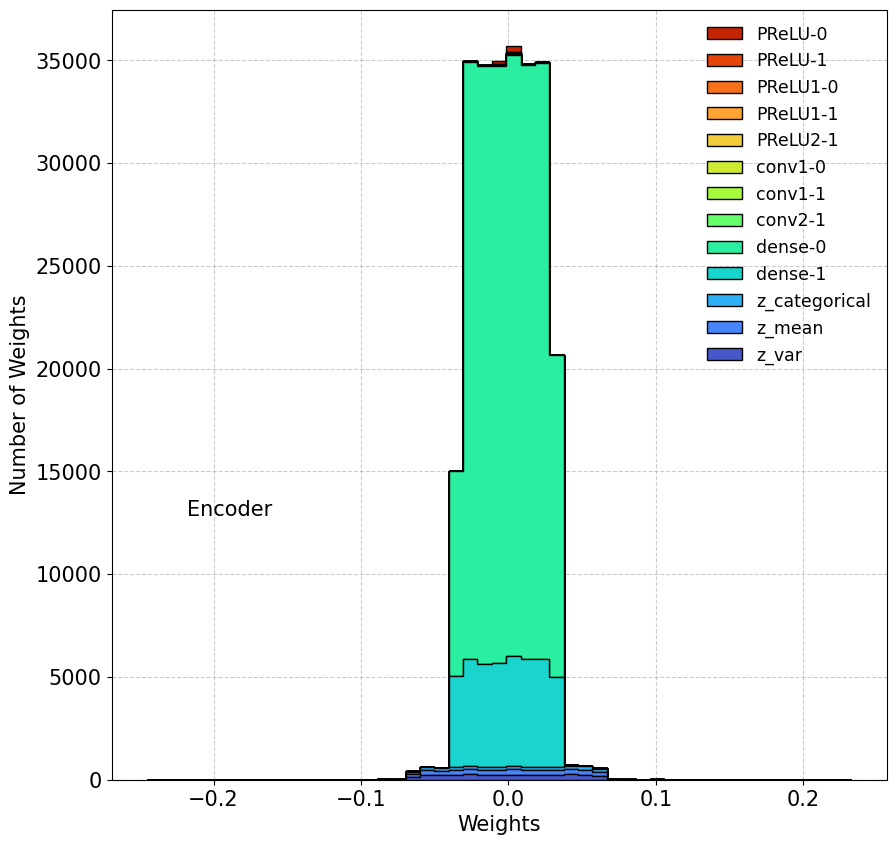

-0.111281164
0.1878272


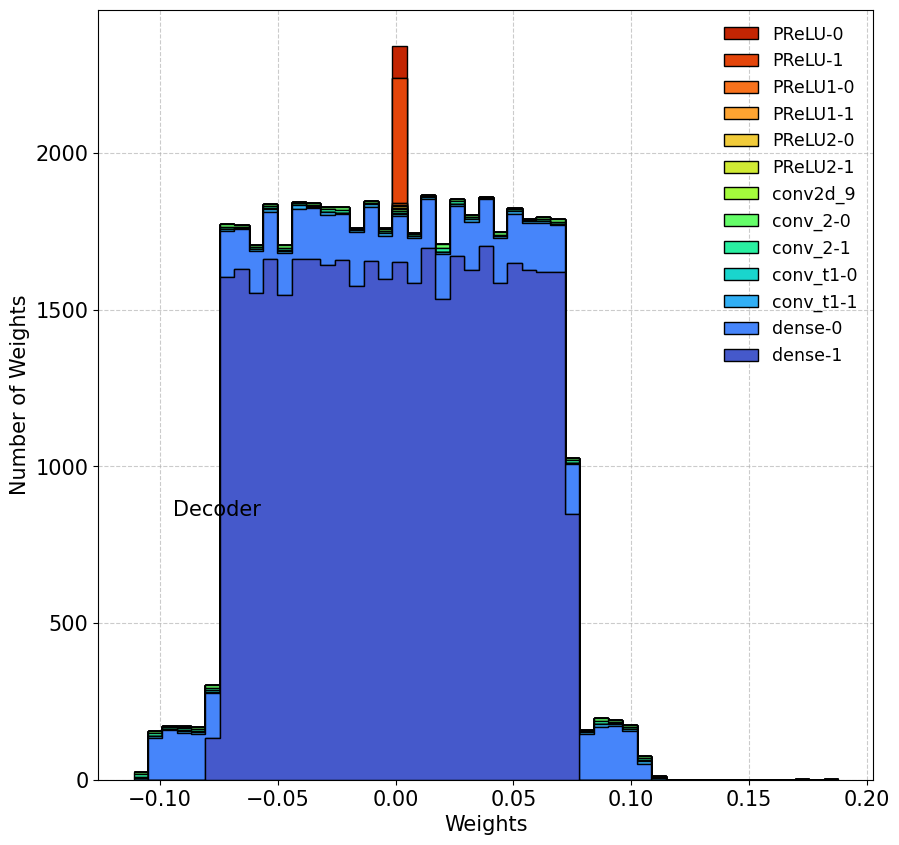

In [ ]:
ad.plot.doWeights(model.encoder)
ad.plot.doWeights(model.decoder)

## AD evaluation

In [ ]:
import sklearn.model_selection

top_train, top_valid = sklearn.model_selection.train_test_split(top['images'], train_size = 0.75 )
ytop_train, ytop_valid = sklearn.model_selection.train_test_split(top['labels'], train_size = 0.75 )

In [ ]:
from ad import utils
del top_train, ytop_train,# x_train, y_train,
utils.free_mem()

27106

In [ ]:
scores = ad.evaluation.compute_scores(model, x= np.concatenate((x_valid, top_valid),axis=0), batch_size=128)#256)
scores = {k: v.reshape((-1, 1)) for k, v in scores.items()}
scores =ad.evaluation.latents_as_scores(scores, np.concatenate ((y_valid, ytop_valid),axis=0), np.concatenate ((y_valid, ytop_valid),axis=0))

## AD plots

TPR corrispondent to 0.1% of FPR: 0.00033746898263027294
energy_diff_1 (1), AUC = 28.38%


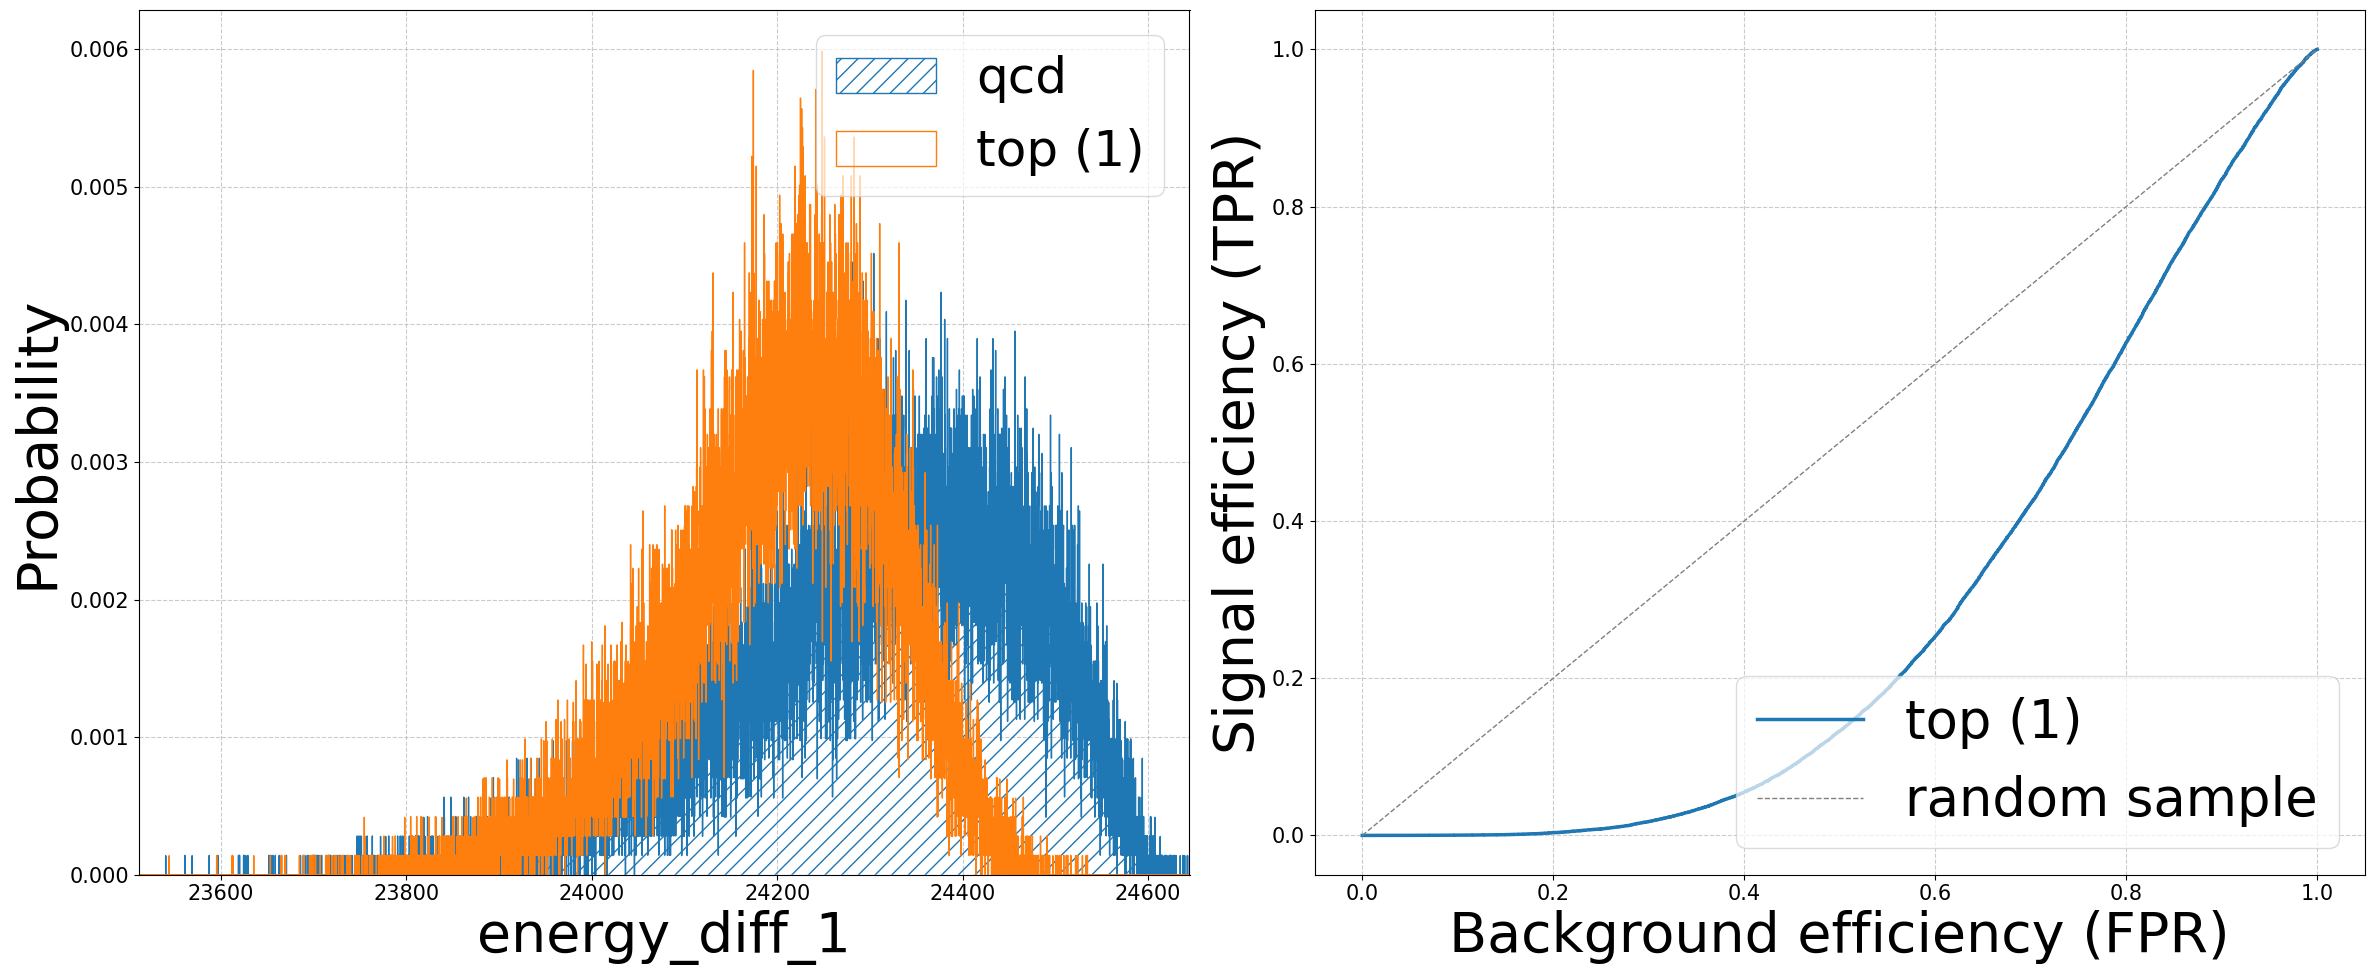

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


TPR corrispondent to 0.1% of FPR: 0.00230272952853598
bce_1 (1), AUC = 29.24%


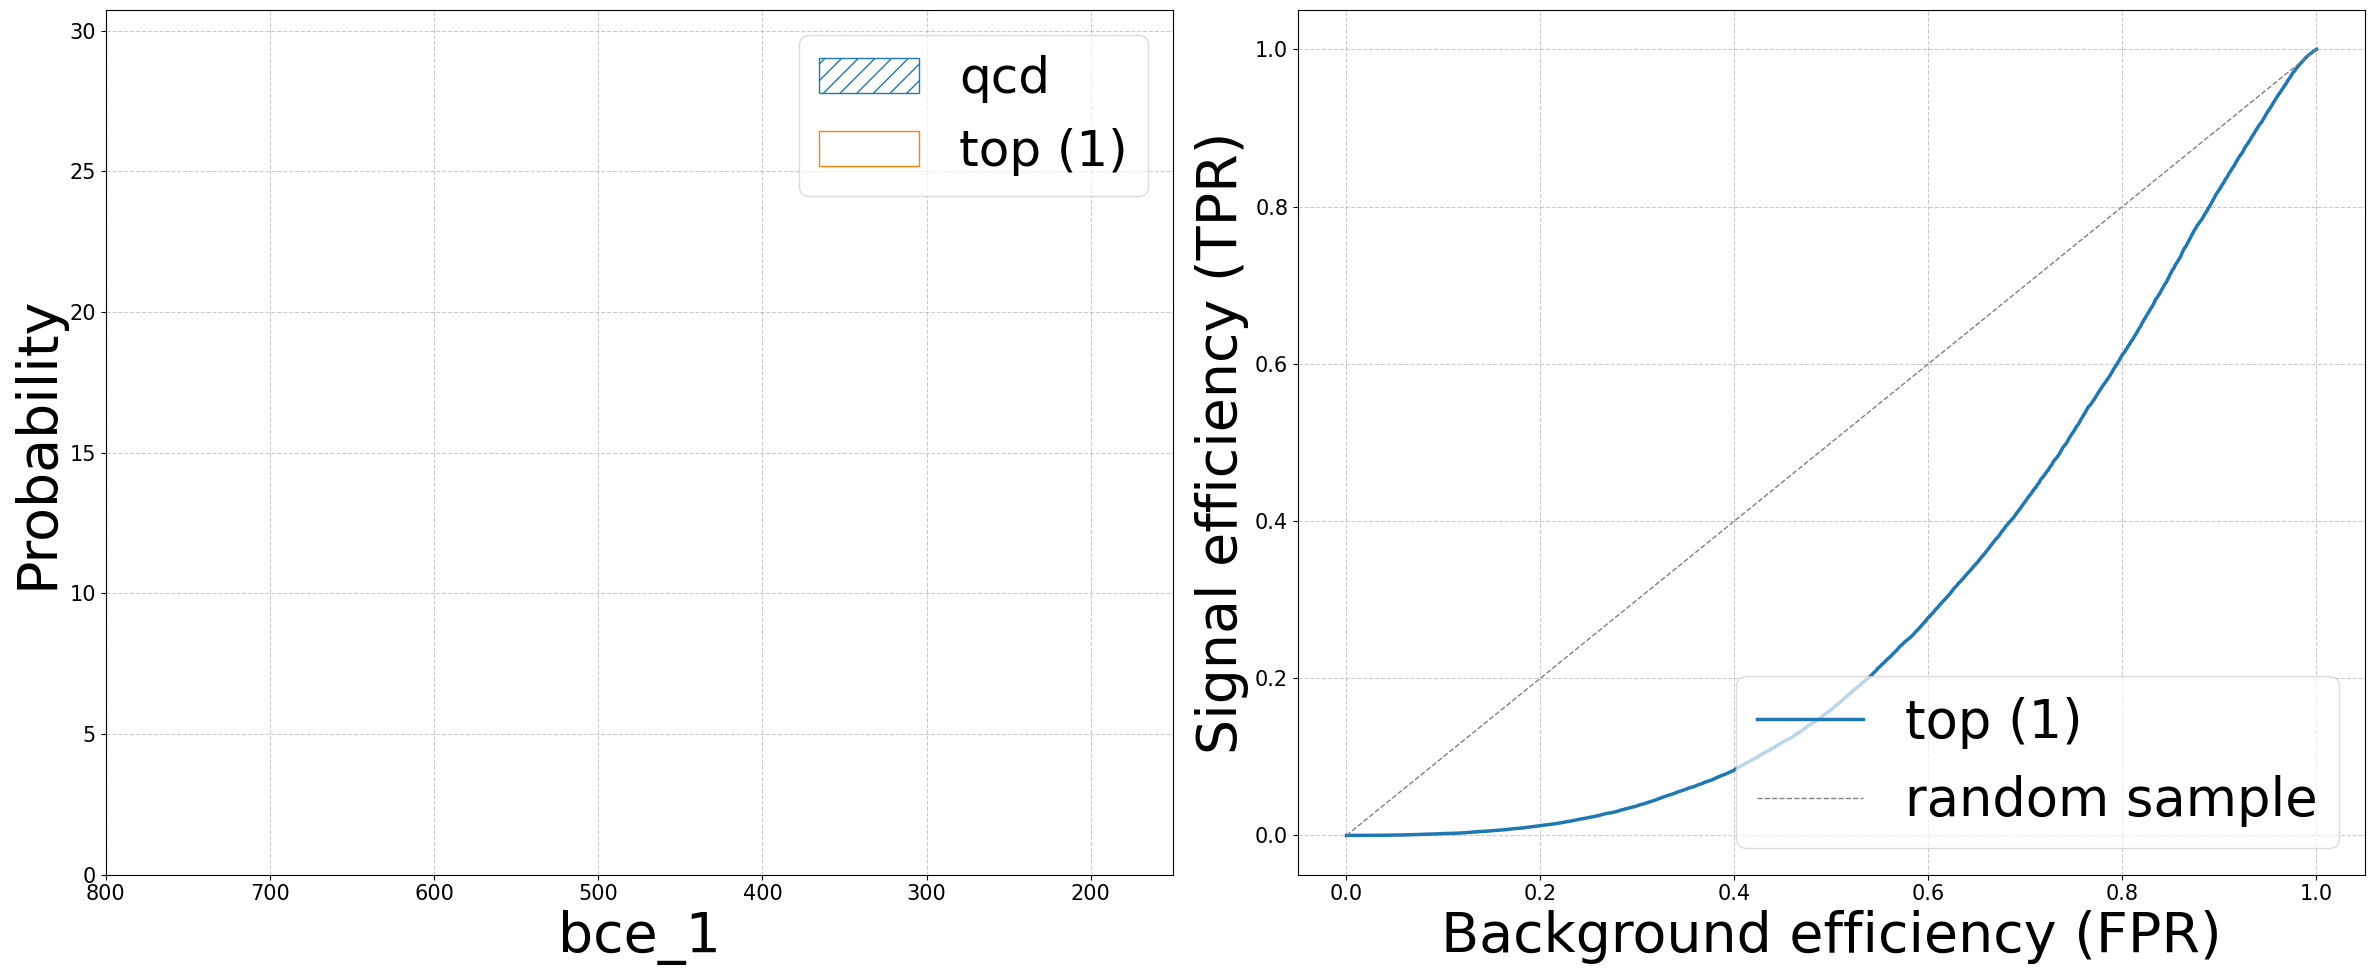

TPR corrispondent to 0.1% of FPR: 0.0
dice_1 (1), AUC = 50.0%


/content/JointVAE4AD/ad/plot.py:400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(*plot_range)


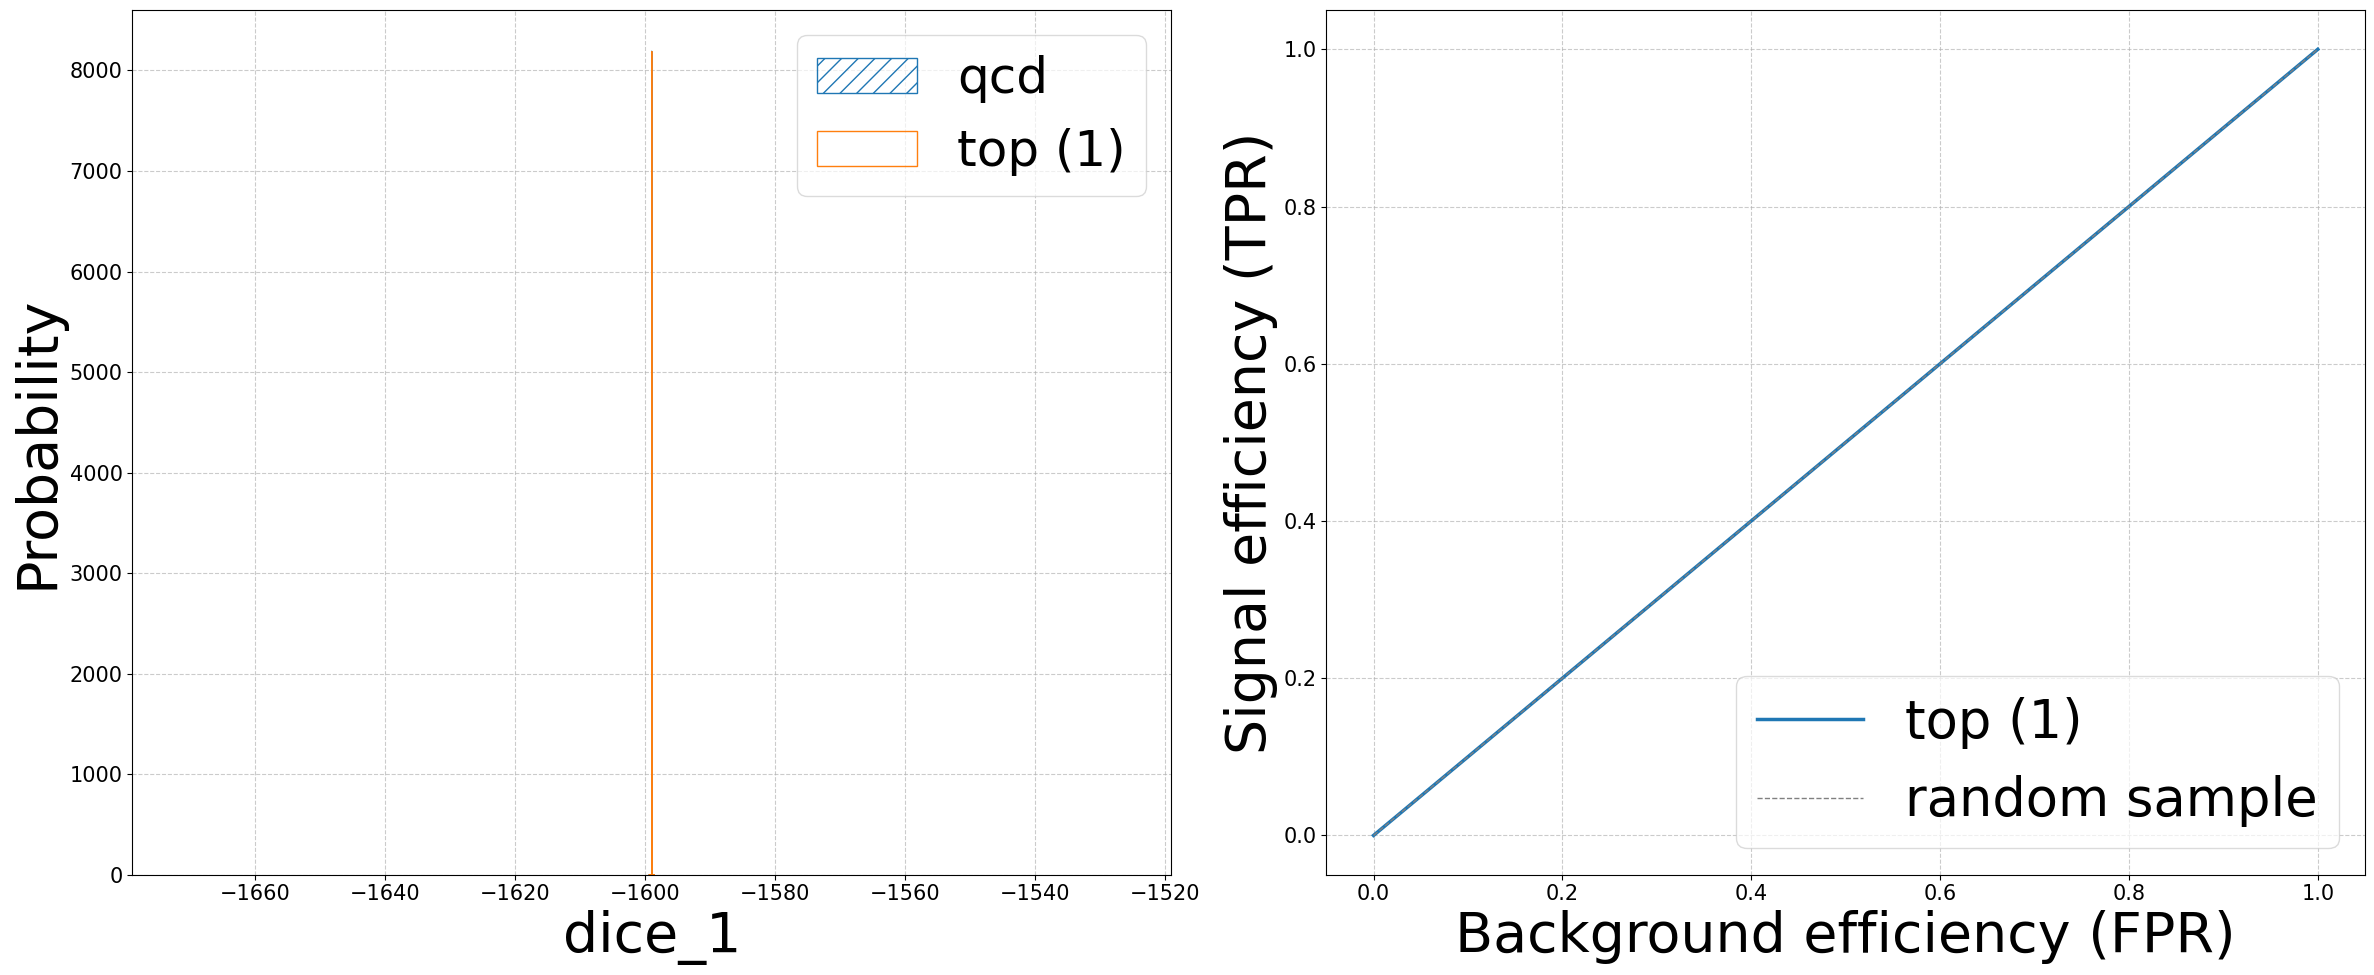

TPR corrispondent to 0.1% of FPR: 0.00033746898263027294
total_1 (1), AUC = 28.38%


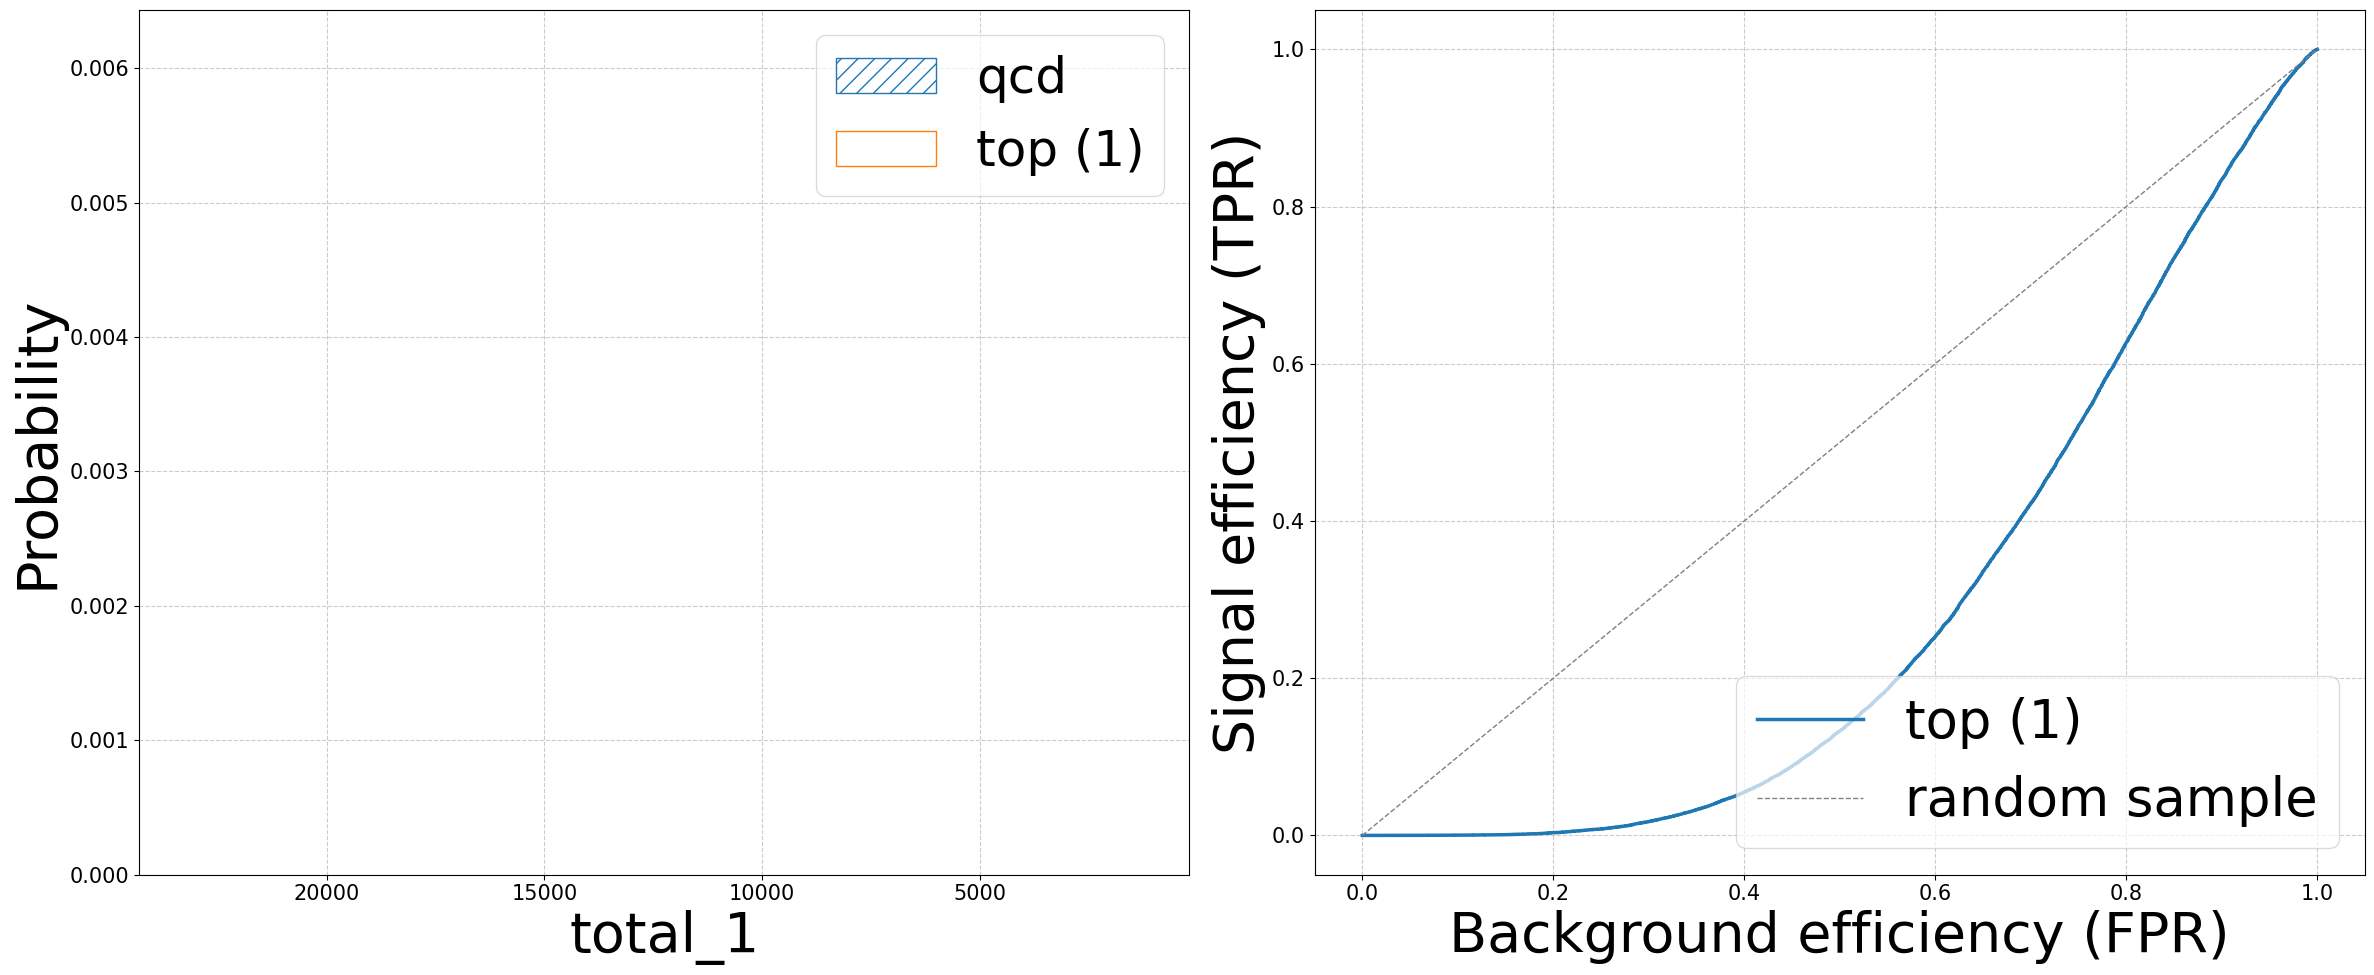

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


TPR corrispondent to 0.1% of FPR: 0.00230272952853598
mse_1 (1), AUC = 29.24%


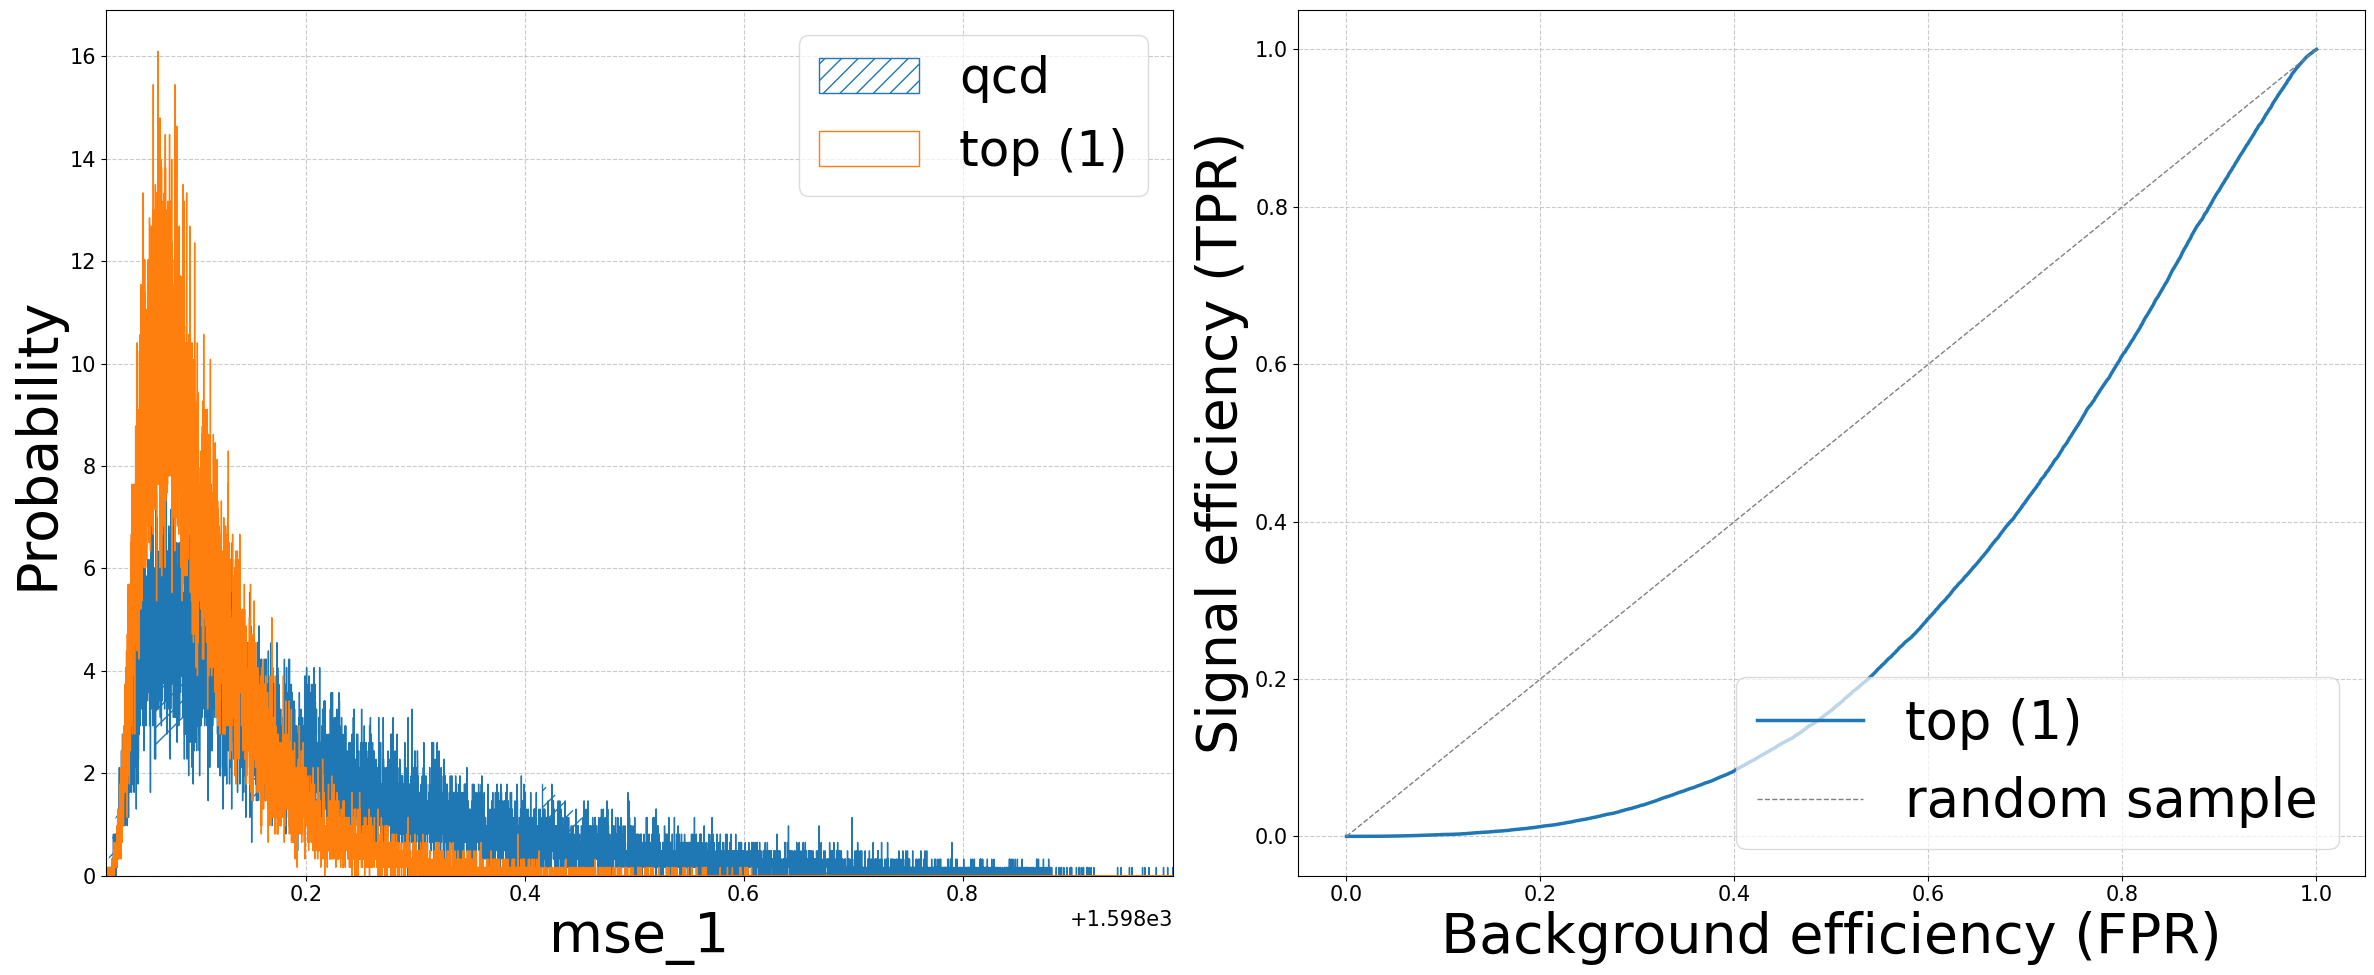

TPR corrispondent to 0.1% of FPR: 0.0
kl_cont_1 (1), AUC = 49.95%


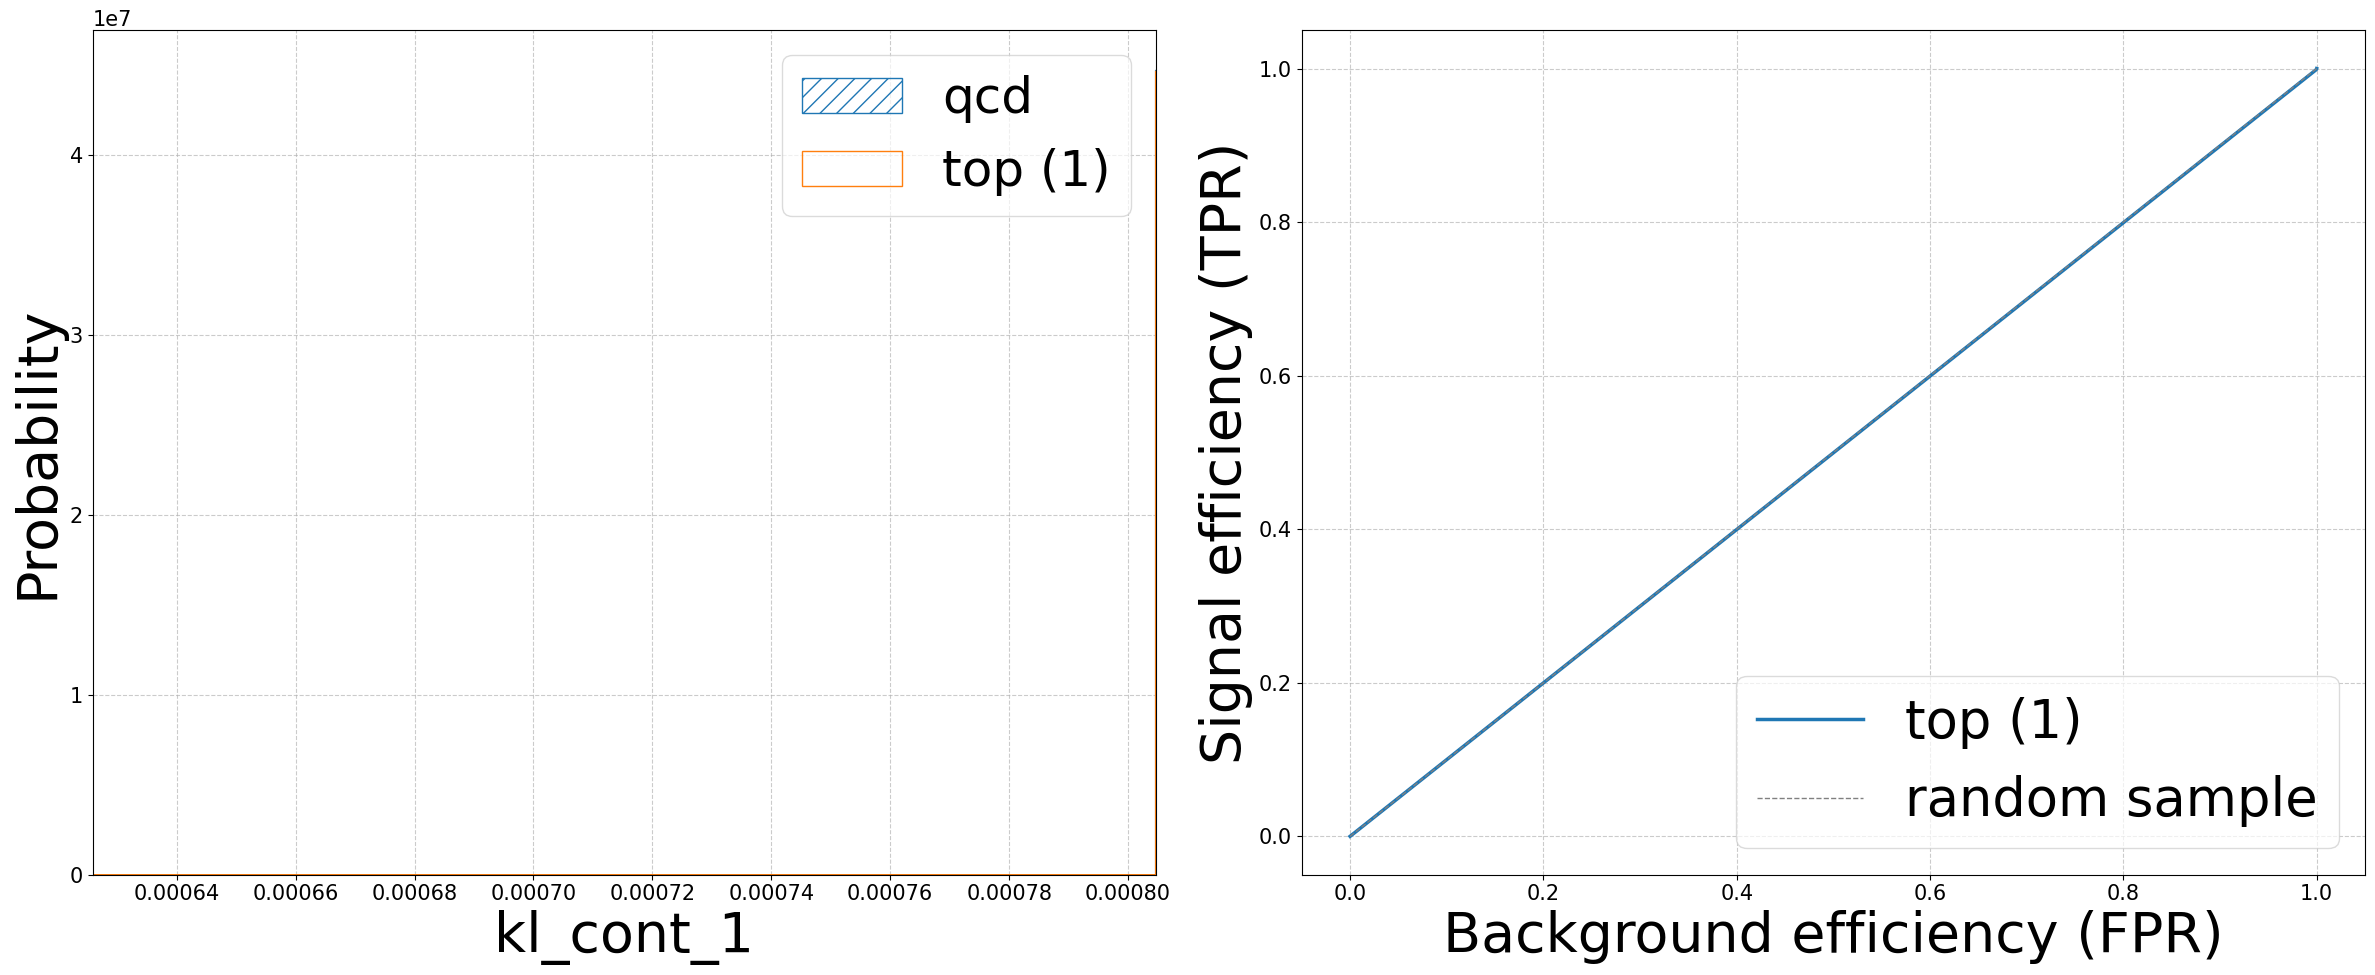

TPR corrispondent to 0.1% of FPR: 0.0
kl_disc_1 (1), AUC = 50.0%


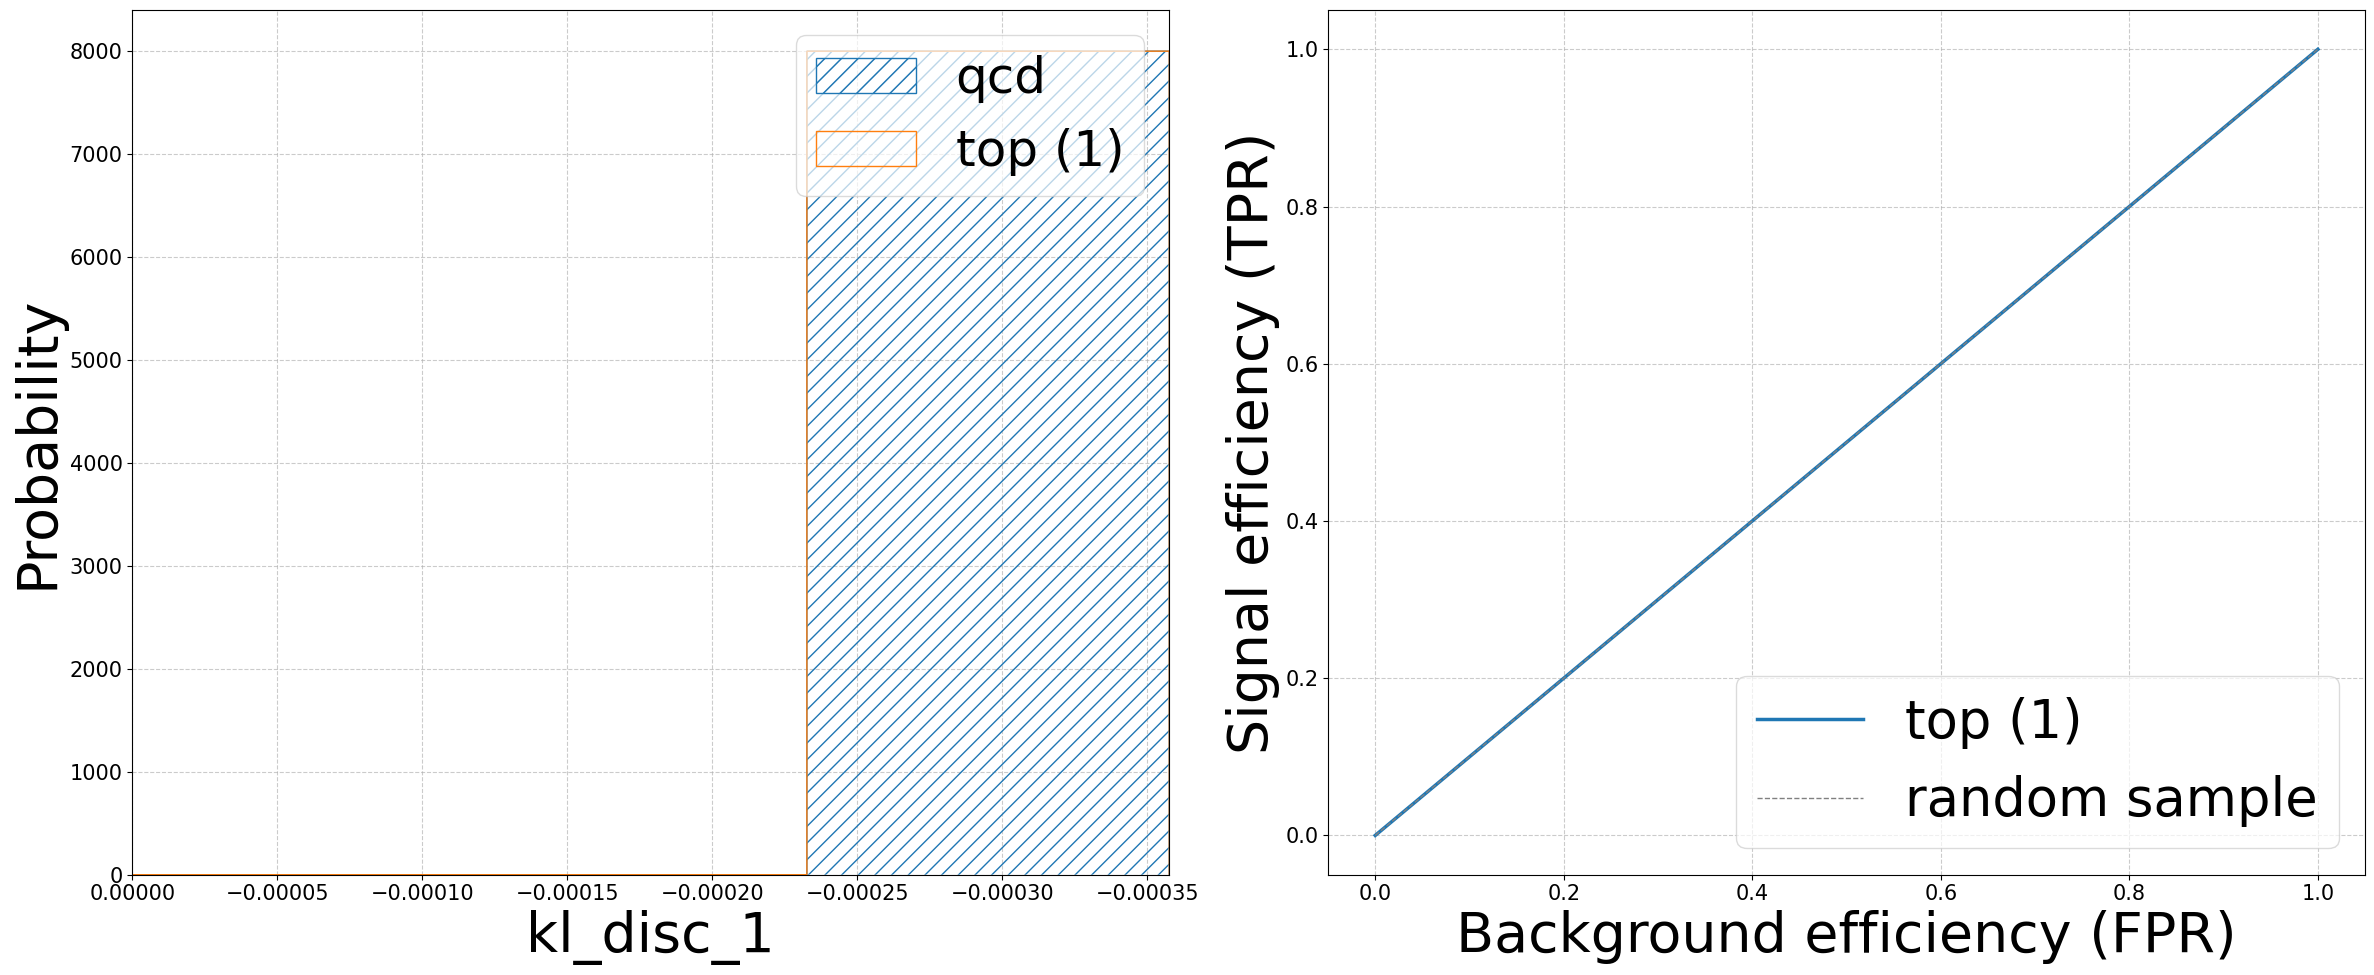

TPR corrispondent to 0.1% of FPR: 0.0
kl_tot_1 (1), AUC = 49.95%


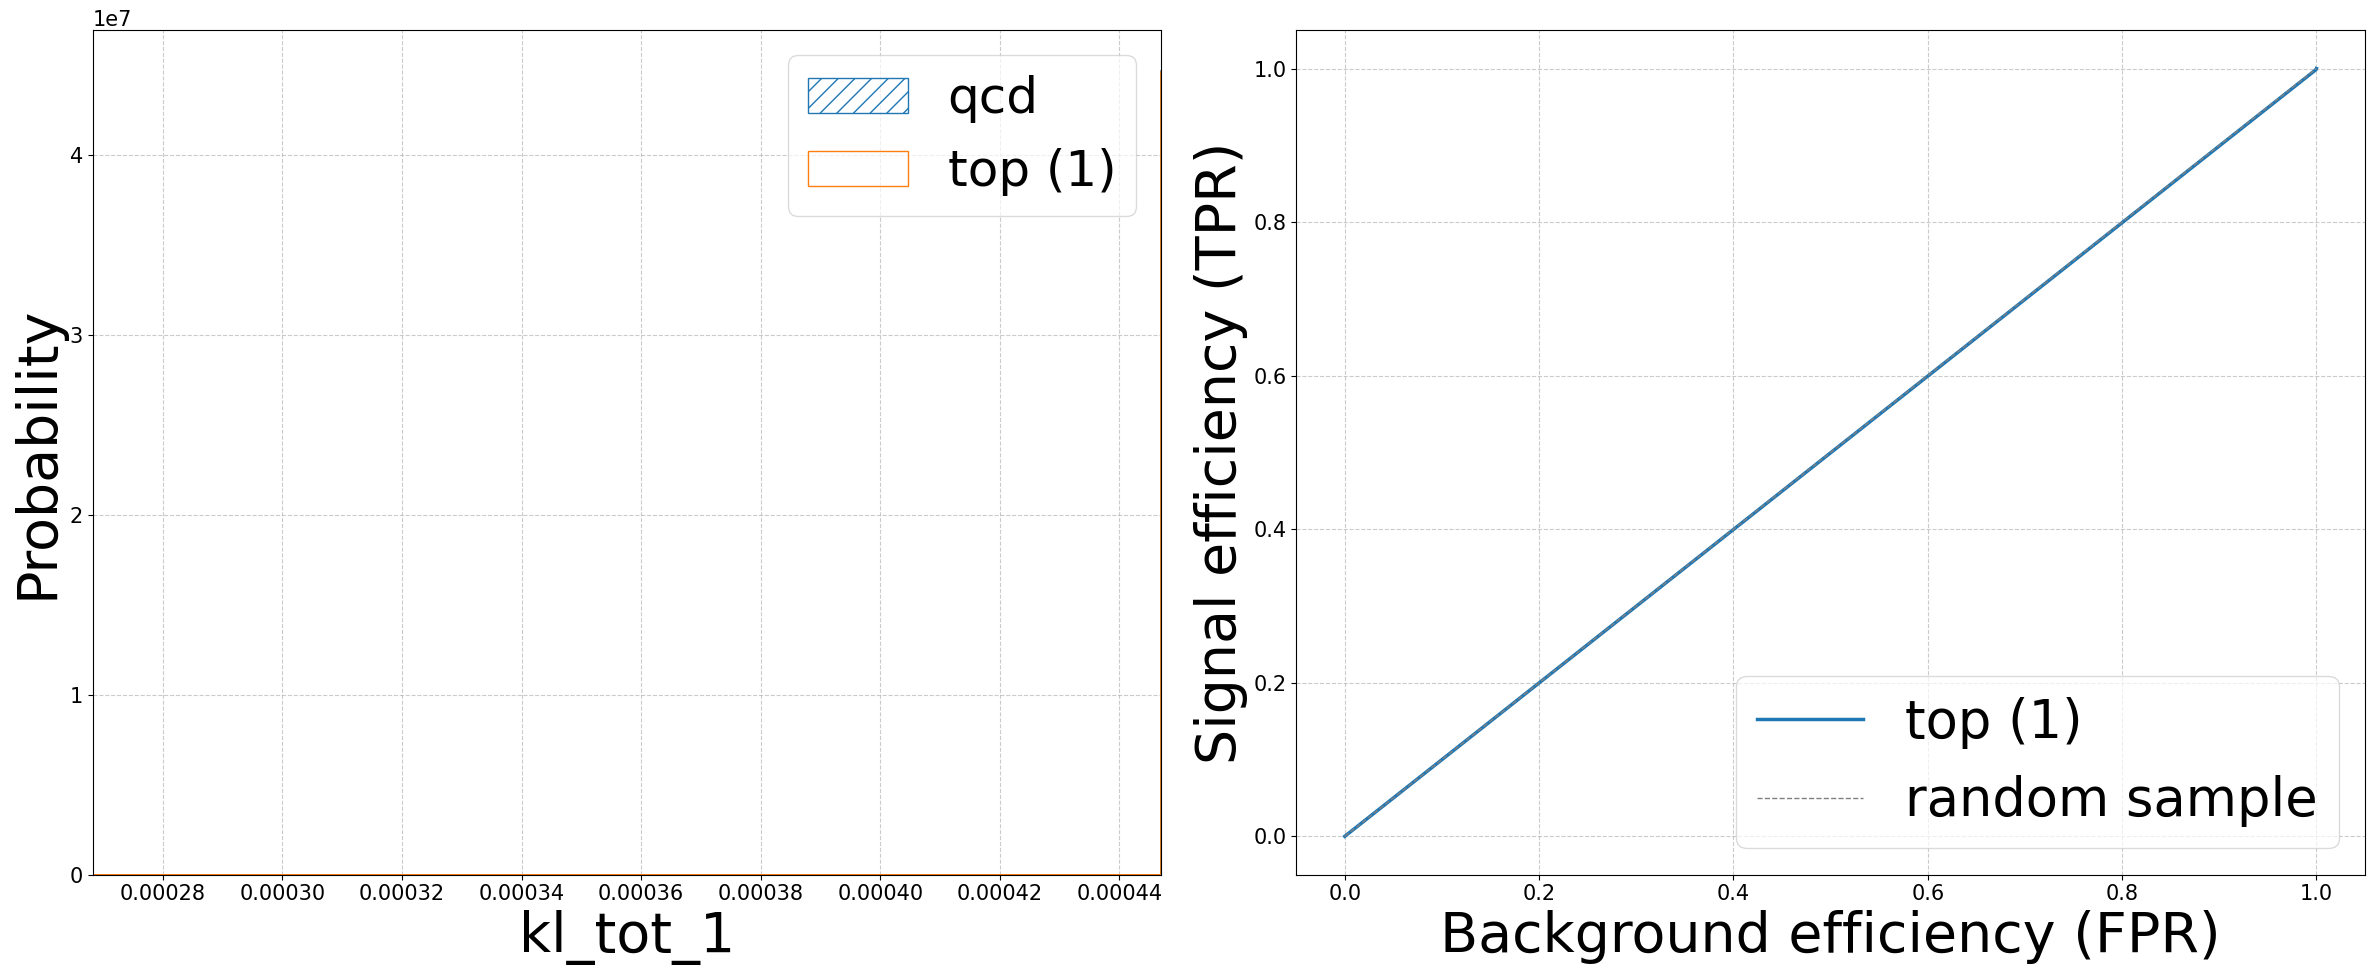

In [ ]:
curves = ad.plot.roc_per_mass(bkg_scores=scores['qcd'],
                              signal_scores=scores['top'],
                              bins = 8000,
                              fontsize=40,
                              x_limits={'bce_1': (0, 150),
                                        'total_1': (0, 180),
                                        'kl_cont_1': (0, 7.5),
                                        'kl_disc_1': (0, .14),
                                        'kl_tot_1': (0, 7.5), },
                              )